In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-data-in-india/city_day.csv
/kaggle/input/air-quality-data-in-india/stations.csv
/kaggle/input/air-quality-data-in-india/station_hour.csv
/kaggle/input/air-quality-data-in-india/station_day.csv
/kaggle/input/air-quality-data-in-india/city_hour.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import accuracy_score
import warnings; 
warnings.simplefilter('ignore')


In [4]:
df = pd.read_csv("../input/air-quality-data-in-india/station_hour.csv")
pm25 = df[['StationId', 'Datetime', 'PM2.5']]

max = 0 
min = 99999
for i in pm25.loc[:,'StationId'].unique():
    alpha = pm25.loc[pm25.loc[:,'StationId']==i]
    alpha.dropna(inplace=True)
    try:
        a = len(alpha)
        b = len(pd.date_range(start = str(alpha.iloc[0,1]), end = str(alpha.iloc[-1,1]) , freq='D').difference(alpha.iloc[:,1]))
        print(i,'\t',a, '\t',b ,'\t',a - b )
        if (a-b) > max:
            max = a-b
            beta = i 
        if b < min:
            min = b
            gamma = i
    except:
        print(i)
print("MAX Difference:\t",beta)
print("MIN Missing:\t",gamma)

AP001 	 19233 	 950 	 18283
AP005 	 26157 	 1461 	 24696
AS001 	 11558 	 501 	 11057
BR005 	 589 	 113 	 476
BR006 	 2463 	 120 	 2343
BR007 	 31052 	 1735 	 29317
BR008 	 4315 	 190 	 4125
BR009 	 4353 	 190 	 4163
BR010 	 4388 	 190 	 4198
CH001 	 6599 	 303 	 6296
DL001 	 13530 	 598 	 12932
DL002 	 36268 	 1915 	 34353
DL003 	 20728 	 881 	 19847
DL004 	 21636 	 1028 	 20608
DL005 	 16906 	 728 	 16178
DL006 	 14965 	 835 	 14130
DL007 	 27712 	 2008 	 25704
DL008 	 22177 	 1927 	 20250
DL009 	 18423 	 879 	 17544
DL010 	 20865 	 881 	 19984
DL011
DL012 	 22427 	 1035 	 21392
DL013 	 28899 	 2008 	 26891
DL014 	 21528 	 2000 	 19528
DL015 	 20657 	 881 	 19776
DL016 	 20456 	 881 	 19575
DL017 	 21878 	 1028 	 20850
DL018 	 20868 	 881 	 19987
DL019 	 31740 	 1910 	 29830
DL020 	 16896 	 729 	 16167
DL021 	 36400 	 1927 	 34473
DL022 	 19949 	 881 	 19068
DL023 	 20263 	 881 	 19382
DL024 	 20860 	 881 	 19979
DL025 	 21255 	 1035 	 20220
DL026 	 20644 	 881 	 19763
DL027 	 20699 	

In [5]:
from dask.distributed import Client
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

client = Client()

In [21]:
pm25_UP012 = pm25.loc[pm25.loc[:,'StationId']=='UP012']
pm25_UP012.pop('StationId')
pm25_UP012.columns = ['ds','y']
pm25_UP012.dropna(inplace=True)
pm25_UP012_train = pm25_UP012.iloc[:-int(len(pm25_UP012)*0.1),:]
pm25_UP012_test = pm25_UP012.iloc[-int(len(pm25_UP012)*0.1):,:]

                       ds       yhat  yhat_lower  yhat_upper
35227 2020-02-07 05:00:00  69.552506  -11.142193  154.987930
35228 2020-02-08 05:00:00  73.724742  -13.320307  153.996865
35229 2020-02-09 05:00:00  75.392931   -7.959582  156.587100
35230 2020-02-10 05:00:00  71.781265  -13.911284  162.836343
35231 2020-02-11 05:00:00  64.584924  -13.487146  146.379994


<Figure size 1080x720 with 0 Axes>

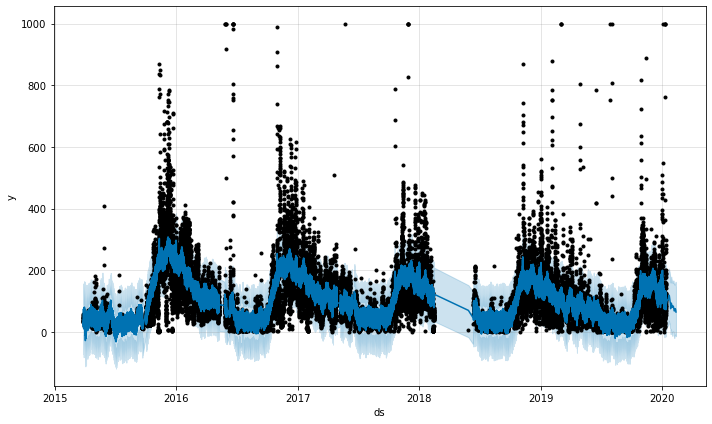

In [7]:
m = Prophet(weekly_seasonality=False, yearly_seasonality=20)
m.add_country_holidays(country_name='IN')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(pm25_UP012_train)

future = m.make_future_dataframe(periods=30, freq='D', include_history=True)
forecast = m.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
plt.figure(figsize=(15,10))
fig1 = m.plot(forecast)
plt.show(fig1)

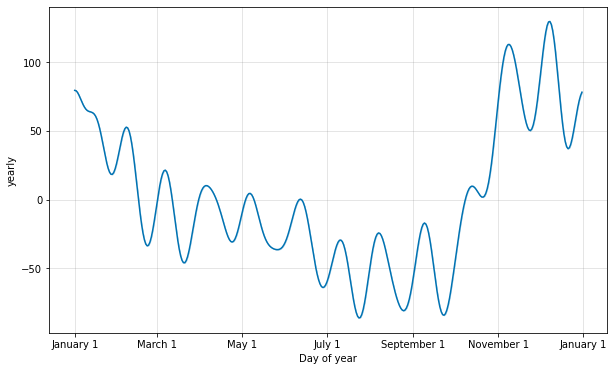

In [8]:
from fbprophet.plot import plot_yearly
a = plot_yearly(m)

In [90]:
list(forecast.columns.values.ravel()).index('daily')

75

In [95]:
pm25_UP012_test['ds'] = [str(x) for x in pm25_UP012_test['ds']]
forecast['ds'] = [str(x) for x in forecast['ds']]


pm25_UP012['ds'] = [str(x) for x in pm25_UP012['ds']]

In [100]:
y = []
yhat = []

for i in [x for x in pm25_UP012['ds']]:
#     print(i)
    if i in [x for x in forecast['ds']]:
        print(i)
        y.append(pm25_UP012.iloc[[x for x in pm25_UP012['ds']].index(i), -1])
        yhat.append(forecast.iloc[[x for x in forecast['ds']].index(i), -1])

2015-03-28 14:00:00
2015-03-28 15:00:00
2015-03-28 16:00:00
2015-03-28 17:00:00
2015-03-28 18:00:00
2015-03-28 19:00:00
2015-03-28 20:00:00
2015-03-28 21:00:00
2015-03-28 22:00:00
2015-03-28 23:00:00
2015-03-29 00:00:00
2015-03-29 01:00:00
2015-03-29 02:00:00
2015-03-29 03:00:00
2015-03-29 04:00:00
2015-03-29 05:00:00
2015-03-29 06:00:00
2015-03-29 07:00:00
2015-03-29 08:00:00
2015-03-29 09:00:00
2015-03-29 10:00:00
2015-03-29 11:00:00
2015-03-29 12:00:00
2015-03-29 13:00:00
2015-03-29 14:00:00
2015-03-29 15:00:00
2015-03-29 16:00:00
2015-03-29 17:00:00
2015-03-29 18:00:00
2015-03-29 19:00:00
2015-03-29 20:00:00
2015-03-29 21:00:00
2015-03-29 22:00:00
2015-03-29 23:00:00
2015-03-30 09:00:00
2015-03-30 10:00:00
2015-03-30 11:00:00
2015-03-30 12:00:00
2015-03-30 13:00:00
2015-03-30 14:00:00
2015-03-30 15:00:00
2015-03-30 16:00:00
2015-03-30 17:00:00
2015-03-30 18:00:00
2015-03-30 19:00:00
2015-03-30 20:00:00
2015-03-30 21:00:00
2015-03-30 22:00:00
2015-03-30 23:00:00
2015-03-31 00:00:00


2015-04-15 10:00:00
2015-04-15 11:00:00
2015-04-15 12:00:00
2015-04-15 13:00:00
2015-04-15 14:00:00
2015-04-15 15:00:00
2015-04-15 16:00:00
2015-04-15 17:00:00
2015-04-15 18:00:00
2015-04-15 19:00:00
2015-04-15 20:00:00
2015-04-15 21:00:00
2015-04-15 22:00:00
2015-04-15 23:00:00
2015-04-16 00:00:00
2015-04-16 01:00:00
2015-04-16 02:00:00
2015-04-16 03:00:00
2015-04-16 04:00:00
2015-04-16 05:00:00
2015-04-16 06:00:00
2015-04-16 07:00:00
2015-04-16 08:00:00
2015-04-16 09:00:00
2015-04-16 10:00:00
2015-04-16 11:00:00
2015-04-16 12:00:00
2015-04-16 13:00:00
2015-04-16 14:00:00
2015-04-16 15:00:00
2015-04-16 16:00:00
2015-04-16 17:00:00
2015-04-16 18:00:00
2015-04-16 19:00:00
2015-04-16 20:00:00
2015-04-16 21:00:00
2015-04-16 22:00:00
2015-04-16 23:00:00
2015-04-17 00:00:00
2015-04-17 01:00:00
2015-04-17 02:00:00
2015-04-17 03:00:00
2015-04-17 04:00:00
2015-04-17 05:00:00
2015-04-17 06:00:00
2015-04-17 07:00:00
2015-04-17 08:00:00
2015-04-17 09:00:00
2015-04-17 10:00:00
2015-04-17 11:00:00


2015-05-05 23:00:00
2015-05-06 00:00:00
2015-05-06 01:00:00
2015-05-06 02:00:00
2015-05-06 03:00:00
2015-05-06 04:00:00
2015-05-06 05:00:00
2015-05-06 06:00:00
2015-05-06 07:00:00
2015-05-06 08:00:00
2015-05-06 09:00:00
2015-05-06 10:00:00
2015-05-06 11:00:00
2015-05-06 12:00:00
2015-05-06 13:00:00
2015-05-06 14:00:00
2015-05-06 15:00:00
2015-05-06 16:00:00
2015-05-06 17:00:00
2015-05-06 18:00:00
2015-05-06 19:00:00
2015-05-06 20:00:00
2015-05-06 21:00:00
2015-05-06 22:00:00
2015-05-06 23:00:00
2015-05-07 00:00:00
2015-05-07 01:00:00
2015-05-07 02:00:00
2015-05-07 03:00:00
2015-05-07 04:00:00
2015-05-07 05:00:00
2015-05-07 06:00:00
2015-05-07 07:00:00
2015-05-07 08:00:00
2015-05-07 09:00:00
2015-05-07 10:00:00
2015-05-07 11:00:00
2015-05-07 12:00:00
2015-05-07 13:00:00
2015-05-07 14:00:00
2015-05-07 15:00:00
2015-05-07 16:00:00
2015-05-07 17:00:00
2015-05-07 18:00:00
2015-05-07 19:00:00
2015-05-07 20:00:00
2015-05-07 21:00:00
2015-05-07 22:00:00
2015-05-07 23:00:00
2015-05-08 02:00:00


2015-05-24 18:00:00
2015-05-24 19:00:00
2015-05-24 20:00:00
2015-05-24 21:00:00
2015-05-24 22:00:00
2015-05-24 23:00:00
2015-05-25 00:00:00
2015-05-25 01:00:00
2015-05-25 02:00:00
2015-05-25 03:00:00
2015-05-25 04:00:00
2015-05-25 05:00:00
2015-05-25 06:00:00
2015-05-25 07:00:00
2015-05-25 08:00:00
2015-05-25 09:00:00
2015-05-25 11:00:00
2015-05-25 12:00:00
2015-05-25 13:00:00
2015-05-25 14:00:00
2015-05-25 15:00:00
2015-05-25 16:00:00
2015-05-25 17:00:00
2015-05-25 18:00:00
2015-05-25 19:00:00
2015-05-25 20:00:00
2015-05-25 21:00:00
2015-05-25 22:00:00
2015-05-25 23:00:00
2015-05-26 00:00:00
2015-05-26 01:00:00
2015-05-26 02:00:00
2015-05-26 03:00:00
2015-05-26 04:00:00
2015-05-26 09:00:00
2015-05-26 10:00:00
2015-05-26 11:00:00
2015-05-26 12:00:00
2015-05-26 13:00:00
2015-05-26 14:00:00
2015-05-26 15:00:00
2015-05-26 16:00:00
2015-05-26 17:00:00
2015-05-26 18:00:00
2015-05-26 19:00:00
2015-05-26 20:00:00
2015-05-26 21:00:00
2015-05-26 22:00:00
2015-05-26 23:00:00
2015-05-27 00:00:00


2015-06-17 14:00:00
2015-06-17 15:00:00
2015-06-17 16:00:00
2015-06-17 17:00:00
2015-06-17 18:00:00
2015-06-17 19:00:00
2015-06-17 20:00:00
2015-06-17 21:00:00
2015-06-17 22:00:00
2015-06-17 23:00:00
2015-06-18 00:00:00
2015-06-18 01:00:00
2015-06-18 02:00:00
2015-06-18 03:00:00
2015-06-18 04:00:00
2015-06-18 05:00:00
2015-06-18 06:00:00
2015-06-18 07:00:00
2015-06-18 08:00:00
2015-06-18 09:00:00
2015-06-18 10:00:00
2015-06-18 11:00:00
2015-06-18 12:00:00
2015-06-18 13:00:00
2015-06-18 14:00:00
2015-06-18 15:00:00
2015-06-18 16:00:00
2015-06-18 17:00:00
2015-06-18 18:00:00
2015-06-18 19:00:00
2015-06-18 20:00:00
2015-06-18 21:00:00
2015-06-18 22:00:00
2015-06-18 23:00:00
2015-06-19 00:00:00
2015-06-19 01:00:00
2015-06-19 02:00:00
2015-06-19 03:00:00
2015-06-19 04:00:00
2015-06-19 05:00:00
2015-06-19 06:00:00
2015-06-19 07:00:00
2015-06-19 08:00:00
2015-06-19 09:00:00
2015-06-19 10:00:00
2015-06-19 11:00:00
2015-06-19 12:00:00
2015-06-19 13:00:00
2015-06-19 14:00:00
2015-06-19 15:00:00


2015-07-06 11:00:00
2015-07-06 12:00:00
2015-07-06 13:00:00
2015-07-06 14:00:00
2015-07-06 15:00:00
2015-07-06 16:00:00
2015-07-06 17:00:00
2015-07-06 18:00:00
2015-07-06 19:00:00
2015-07-06 20:00:00
2015-07-06 21:00:00
2015-07-06 22:00:00
2015-07-06 23:00:00
2015-07-07 00:00:00
2015-07-07 01:00:00
2015-07-07 02:00:00
2015-07-07 03:00:00
2015-07-07 04:00:00
2015-07-07 05:00:00
2015-07-07 06:00:00
2015-07-07 07:00:00
2015-07-07 08:00:00
2015-07-07 09:00:00
2015-07-07 10:00:00
2015-07-07 11:00:00
2015-07-07 12:00:00
2015-07-07 13:00:00
2015-07-07 14:00:00
2015-07-07 15:00:00
2015-07-07 16:00:00
2015-07-07 17:00:00
2015-07-07 18:00:00
2015-07-07 19:00:00
2015-07-07 20:00:00
2015-07-07 21:00:00
2015-07-07 22:00:00
2015-07-07 23:00:00
2015-07-08 00:00:00
2015-07-08 01:00:00
2015-07-08 02:00:00
2015-07-08 03:00:00
2015-07-08 04:00:00
2015-07-08 05:00:00
2015-07-08 06:00:00
2015-07-08 07:00:00
2015-07-08 08:00:00
2015-07-08 09:00:00
2015-07-08 10:00:00
2015-07-08 11:00:00
2015-07-08 12:00:00


2015-07-26 09:00:00
2015-07-26 10:00:00
2015-07-26 11:00:00
2015-07-26 12:00:00
2015-07-26 13:00:00
2015-07-26 14:00:00
2015-07-26 15:00:00
2015-07-26 16:00:00
2015-07-26 17:00:00
2015-07-26 18:00:00
2015-07-26 19:00:00
2015-07-26 20:00:00
2015-07-26 21:00:00
2015-07-26 22:00:00
2015-07-26 23:00:00
2015-07-27 00:00:00
2015-07-27 01:00:00
2015-07-27 02:00:00
2015-07-27 03:00:00
2015-07-27 04:00:00
2015-07-27 05:00:00
2015-07-27 06:00:00
2015-07-27 07:00:00
2015-07-27 08:00:00
2015-07-27 09:00:00
2015-07-27 10:00:00
2015-07-27 11:00:00
2015-07-27 12:00:00
2015-07-27 13:00:00
2015-07-27 14:00:00
2015-07-27 15:00:00
2015-07-27 16:00:00
2015-07-27 17:00:00
2015-07-27 18:00:00
2015-07-27 19:00:00
2015-07-27 20:00:00
2015-07-27 21:00:00
2015-07-27 22:00:00
2015-07-27 23:00:00
2015-07-28 00:00:00
2015-07-28 01:00:00
2015-07-28 02:00:00
2015-07-28 03:00:00
2015-07-28 04:00:00
2015-07-28 05:00:00
2015-07-28 06:00:00
2015-07-28 07:00:00
2015-07-28 08:00:00
2015-07-28 09:00:00
2015-07-28 10:00:00


2015-08-13 01:00:00
2015-08-13 02:00:00
2015-08-13 03:00:00
2015-08-13 04:00:00
2015-08-13 05:00:00
2015-08-13 06:00:00
2015-08-13 07:00:00
2015-08-13 08:00:00
2015-08-13 09:00:00
2015-08-13 10:00:00
2015-08-13 11:00:00
2015-08-13 12:00:00
2015-08-13 13:00:00
2015-08-13 14:00:00
2015-08-13 15:00:00
2015-08-13 16:00:00
2015-08-13 17:00:00
2015-08-13 18:00:00
2015-08-13 19:00:00
2015-08-13 20:00:00
2015-08-13 21:00:00
2015-08-13 22:00:00
2015-08-13 23:00:00
2015-08-14 00:00:00
2015-08-14 01:00:00
2015-08-14 02:00:00
2015-08-14 03:00:00
2015-08-14 04:00:00
2015-08-14 05:00:00
2015-08-14 06:00:00
2015-08-14 07:00:00
2015-08-14 08:00:00
2015-08-14 09:00:00
2015-08-14 10:00:00
2015-08-14 11:00:00
2015-08-14 12:00:00
2015-08-14 13:00:00
2015-08-14 14:00:00
2015-08-14 15:00:00
2015-08-14 16:00:00
2015-08-14 17:00:00
2015-08-14 18:00:00
2015-08-14 19:00:00
2015-08-14 20:00:00
2015-08-14 21:00:00
2015-08-14 22:00:00
2015-08-14 23:00:00
2015-08-15 00:00:00
2015-08-15 01:00:00
2015-08-15 02:00:00


2015-08-31 01:00:00
2015-08-31 02:00:00
2015-08-31 03:00:00
2015-08-31 04:00:00
2015-08-31 05:00:00
2015-08-31 06:00:00
2015-08-31 07:00:00
2015-08-31 08:00:00
2015-08-31 09:00:00
2015-08-31 10:00:00
2015-08-31 11:00:00
2015-08-31 12:00:00
2015-08-31 13:00:00
2015-08-31 14:00:00
2015-08-31 15:00:00
2015-08-31 16:00:00
2015-08-31 17:00:00
2015-08-31 18:00:00
2015-08-31 19:00:00
2015-08-31 20:00:00
2015-08-31 21:00:00
2015-08-31 22:00:00
2015-08-31 23:00:00
2015-09-01 00:00:00
2015-09-01 01:00:00
2015-09-01 02:00:00
2015-09-01 03:00:00
2015-09-01 04:00:00
2015-09-01 05:00:00
2015-09-01 06:00:00
2015-09-01 07:00:00
2015-09-01 08:00:00
2015-09-01 09:00:00
2015-09-01 10:00:00
2015-09-01 11:00:00
2015-09-01 12:00:00
2015-09-01 13:00:00
2015-09-01 14:00:00
2015-09-01 15:00:00
2015-09-01 16:00:00
2015-09-01 17:00:00
2015-09-01 18:00:00
2015-09-01 19:00:00
2015-09-01 20:00:00
2015-09-01 21:00:00
2015-09-01 22:00:00
2015-09-01 23:00:00
2015-09-02 00:00:00
2015-09-02 01:00:00
2015-09-02 02:00:00


2015-09-17 10:00:00
2015-09-17 11:00:00
2015-09-17 12:00:00
2015-09-17 13:00:00
2015-09-17 14:00:00
2015-09-17 15:00:00
2015-09-17 16:00:00
2015-09-17 17:00:00
2015-09-17 18:00:00
2015-09-17 19:00:00
2015-09-17 20:00:00
2015-09-17 21:00:00
2015-09-17 22:00:00
2015-09-17 23:00:00
2015-09-18 00:00:00
2015-09-18 01:00:00
2015-09-18 02:00:00
2015-09-18 03:00:00
2015-09-18 04:00:00
2015-09-18 05:00:00
2015-09-18 06:00:00
2015-09-18 07:00:00
2015-09-18 08:00:00
2015-09-18 09:00:00
2015-09-18 10:00:00
2015-09-18 11:00:00
2015-09-18 12:00:00
2015-09-18 13:00:00
2015-09-18 14:00:00
2015-09-18 15:00:00
2015-09-18 16:00:00
2015-09-18 17:00:00
2015-09-18 18:00:00
2015-09-18 19:00:00
2015-09-18 20:00:00
2015-09-18 21:00:00
2015-09-18 22:00:00
2015-09-18 23:00:00
2015-09-19 00:00:00
2015-09-19 01:00:00
2015-09-19 02:00:00
2015-09-19 03:00:00
2015-09-19 04:00:00
2015-09-19 05:00:00
2015-09-19 06:00:00
2015-09-19 07:00:00
2015-09-19 08:00:00
2015-09-19 09:00:00
2015-09-19 10:00:00
2015-09-19 11:00:00


2015-10-15 11:00:00
2015-10-15 12:00:00
2015-10-15 13:00:00
2015-10-15 14:00:00
2015-10-15 15:00:00
2015-10-15 16:00:00
2015-10-15 17:00:00
2015-10-15 18:00:00
2015-10-15 19:00:00
2015-10-15 20:00:00
2015-10-15 21:00:00
2015-10-15 22:00:00
2015-10-15 23:00:00
2015-10-16 00:00:00
2015-10-16 01:00:00
2015-10-16 02:00:00
2015-10-16 03:00:00
2015-10-16 04:00:00
2015-10-16 05:00:00
2015-10-16 06:00:00
2015-10-16 07:00:00
2015-10-16 08:00:00
2015-10-16 09:00:00
2015-10-16 10:00:00
2015-10-16 11:00:00
2015-10-16 12:00:00
2015-10-16 13:00:00
2015-10-16 14:00:00
2015-10-16 15:00:00
2015-10-16 16:00:00
2015-10-16 17:00:00
2015-10-16 18:00:00
2015-10-16 19:00:00
2015-10-16 20:00:00
2015-10-16 21:00:00
2015-10-16 22:00:00
2015-10-16 23:00:00
2015-10-17 00:00:00
2015-10-17 01:00:00
2015-10-17 02:00:00
2015-10-17 03:00:00
2015-10-17 04:00:00
2015-10-17 05:00:00
2015-10-17 06:00:00
2015-10-17 07:00:00
2015-10-17 08:00:00
2015-10-17 09:00:00
2015-10-17 10:00:00
2015-10-17 11:00:00
2015-10-17 12:00:00


2015-11-02 11:00:00
2015-11-02 12:00:00
2015-11-02 13:00:00
2015-11-02 14:00:00
2015-11-02 15:00:00
2015-11-02 16:00:00
2015-11-02 17:00:00
2015-11-02 18:00:00
2015-11-02 19:00:00
2015-11-02 20:00:00
2015-11-02 21:00:00
2015-11-02 22:00:00
2015-11-02 23:00:00
2015-11-03 00:00:00
2015-11-03 01:00:00
2015-11-03 02:00:00
2015-11-03 03:00:00
2015-11-03 04:00:00
2015-11-03 05:00:00
2015-11-03 06:00:00
2015-11-03 07:00:00
2015-11-03 08:00:00
2015-11-03 09:00:00
2015-11-03 10:00:00
2015-11-03 11:00:00
2015-11-03 12:00:00
2015-11-03 13:00:00
2015-11-03 14:00:00
2015-11-03 15:00:00
2015-11-03 16:00:00
2015-11-03 17:00:00
2015-11-03 18:00:00
2015-11-03 19:00:00
2015-11-03 20:00:00
2015-11-03 21:00:00
2015-11-03 22:00:00
2015-11-03 23:00:00
2015-11-04 00:00:00
2015-11-04 01:00:00
2015-11-04 02:00:00
2015-11-04 03:00:00
2015-11-04 04:00:00
2015-11-04 05:00:00
2015-11-04 06:00:00
2015-11-04 07:00:00
2015-11-04 08:00:00
2015-11-04 09:00:00
2015-11-04 10:00:00
2015-11-04 11:00:00
2015-11-04 12:00:00


2015-11-20 03:00:00
2015-11-20 04:00:00
2015-11-20 05:00:00
2015-11-20 06:00:00
2015-11-20 07:00:00
2015-11-20 08:00:00
2015-11-20 09:00:00
2015-11-20 10:00:00
2015-11-20 11:00:00
2015-11-20 12:00:00
2015-11-20 13:00:00
2015-11-20 14:00:00
2015-11-20 15:00:00
2015-11-20 16:00:00
2015-11-20 17:00:00
2015-11-20 18:00:00
2015-11-20 19:00:00
2015-11-20 20:00:00
2015-11-20 21:00:00
2015-11-20 22:00:00
2015-11-20 23:00:00
2015-11-21 00:00:00
2015-11-21 01:00:00
2015-11-21 02:00:00
2015-11-21 03:00:00
2015-11-21 04:00:00
2015-11-21 05:00:00
2015-11-21 06:00:00
2015-11-21 07:00:00
2015-11-21 08:00:00
2015-11-21 09:00:00
2015-11-21 10:00:00
2015-11-21 11:00:00
2015-11-21 12:00:00
2015-11-21 13:00:00
2015-11-21 14:00:00
2015-11-21 15:00:00
2015-11-21 16:00:00
2015-11-21 17:00:00
2015-11-21 18:00:00
2015-11-21 19:00:00
2015-11-21 20:00:00
2015-11-21 21:00:00
2015-11-21 22:00:00
2015-11-21 23:00:00
2015-11-22 00:00:00
2015-11-22 01:00:00
2015-11-22 02:00:00
2015-11-22 03:00:00
2015-11-22 04:00:00


2015-12-08 03:00:00
2015-12-08 04:00:00
2015-12-08 05:00:00
2015-12-08 06:00:00
2015-12-08 07:00:00
2015-12-08 08:00:00
2015-12-08 09:00:00
2015-12-08 10:00:00
2015-12-08 13:00:00
2015-12-08 14:00:00
2015-12-08 15:00:00
2015-12-08 16:00:00
2015-12-08 17:00:00
2015-12-08 18:00:00
2015-12-08 19:00:00
2015-12-08 20:00:00
2015-12-08 21:00:00
2015-12-08 22:00:00
2015-12-08 23:00:00
2015-12-09 00:00:00
2015-12-09 01:00:00
2015-12-09 02:00:00
2015-12-09 03:00:00
2015-12-09 04:00:00
2015-12-09 05:00:00
2015-12-09 06:00:00
2015-12-09 07:00:00
2015-12-09 08:00:00
2015-12-09 09:00:00
2015-12-09 10:00:00
2015-12-09 14:00:00
2015-12-09 15:00:00
2015-12-09 16:00:00
2015-12-09 17:00:00
2015-12-09 18:00:00
2015-12-09 19:00:00
2015-12-09 20:00:00
2015-12-09 21:00:00
2015-12-09 22:00:00
2015-12-09 23:00:00
2015-12-10 00:00:00
2015-12-10 01:00:00
2015-12-10 02:00:00
2015-12-10 03:00:00
2015-12-10 04:00:00
2015-12-10 05:00:00
2015-12-10 06:00:00
2015-12-10 07:00:00
2015-12-10 08:00:00
2015-12-10 09:00:00


2015-12-26 21:00:00
2015-12-26 22:00:00
2015-12-26 23:00:00
2015-12-27 00:00:00
2015-12-27 01:00:00
2015-12-27 02:00:00
2015-12-27 03:00:00
2015-12-27 04:00:00
2015-12-27 05:00:00
2015-12-27 06:00:00
2015-12-27 07:00:00
2015-12-27 08:00:00
2015-12-27 09:00:00
2015-12-27 10:00:00
2015-12-27 11:00:00
2015-12-27 12:00:00
2015-12-27 13:00:00
2015-12-27 14:00:00
2015-12-27 15:00:00
2015-12-27 16:00:00
2015-12-27 17:00:00
2015-12-27 18:00:00
2015-12-27 19:00:00
2015-12-27 20:00:00
2015-12-27 21:00:00
2015-12-27 22:00:00
2015-12-27 23:00:00
2015-12-28 00:00:00
2015-12-28 01:00:00
2015-12-28 02:00:00
2015-12-28 03:00:00
2015-12-28 04:00:00
2015-12-28 05:00:00
2015-12-28 06:00:00
2015-12-28 07:00:00
2015-12-28 08:00:00
2015-12-28 09:00:00
2015-12-28 10:00:00
2015-12-28 11:00:00
2015-12-28 12:00:00
2015-12-28 13:00:00
2015-12-28 14:00:00
2015-12-28 15:00:00
2015-12-28 16:00:00
2015-12-28 17:00:00
2015-12-28 18:00:00
2015-12-28 19:00:00
2015-12-28 20:00:00
2015-12-28 21:00:00
2015-12-28 22:00:00


2016-01-14 02:00:00
2016-01-14 03:00:00
2016-01-14 04:00:00
2016-01-14 05:00:00
2016-01-14 06:00:00
2016-01-14 07:00:00
2016-01-14 08:00:00
2016-01-14 09:00:00
2016-01-14 10:00:00
2016-01-14 11:00:00
2016-01-14 12:00:00
2016-01-14 13:00:00
2016-01-14 14:00:00
2016-01-14 15:00:00
2016-01-14 16:00:00
2016-01-14 17:00:00
2016-01-14 18:00:00
2016-01-14 19:00:00
2016-01-14 20:00:00
2016-01-14 21:00:00
2016-01-14 22:00:00
2016-01-14 23:00:00
2016-01-15 00:00:00
2016-01-15 01:00:00
2016-01-15 02:00:00
2016-01-15 03:00:00
2016-01-15 04:00:00
2016-01-15 05:00:00
2016-01-15 06:00:00
2016-01-15 07:00:00
2016-01-15 08:00:00
2016-01-15 09:00:00
2016-01-15 10:00:00
2016-01-15 11:00:00
2016-01-15 12:00:00
2016-01-15 13:00:00
2016-01-15 14:00:00
2016-01-15 15:00:00
2016-01-15 16:00:00
2016-01-15 17:00:00
2016-01-15 18:00:00
2016-01-15 19:00:00
2016-01-15 20:00:00
2016-01-15 21:00:00
2016-01-15 22:00:00
2016-01-15 23:00:00
2016-01-16 00:00:00
2016-01-16 01:00:00
2016-01-16 02:00:00
2016-01-16 03:00:00


2016-01-31 15:00:00
2016-01-31 16:00:00
2016-01-31 17:00:00
2016-01-31 18:00:00
2016-01-31 19:00:00
2016-01-31 20:00:00
2016-01-31 21:00:00
2016-01-31 22:00:00
2016-01-31 23:00:00
2016-02-01 00:00:00
2016-02-01 01:00:00
2016-02-01 02:00:00
2016-02-01 03:00:00
2016-02-01 04:00:00
2016-02-01 05:00:00
2016-02-01 06:00:00
2016-02-01 07:00:00
2016-02-01 08:00:00
2016-02-01 09:00:00
2016-02-01 10:00:00
2016-02-01 11:00:00
2016-02-01 12:00:00
2016-02-01 13:00:00
2016-02-01 14:00:00
2016-02-01 15:00:00
2016-02-01 16:00:00
2016-02-01 17:00:00
2016-02-01 18:00:00
2016-02-01 19:00:00
2016-02-01 20:00:00
2016-02-01 21:00:00
2016-02-01 22:00:00
2016-02-01 23:00:00
2016-02-02 00:00:00
2016-02-02 01:00:00
2016-02-02 02:00:00
2016-02-02 03:00:00
2016-02-02 04:00:00
2016-02-02 05:00:00
2016-02-02 06:00:00
2016-02-02 07:00:00
2016-02-02 08:00:00
2016-02-02 09:00:00
2016-02-02 10:00:00
2016-02-02 11:00:00
2016-02-02 12:00:00
2016-02-02 13:00:00
2016-02-02 14:00:00
2016-02-02 15:00:00
2016-02-02 16:00:00


2016-02-22 16:00:00
2016-02-22 17:00:00
2016-02-22 18:00:00
2016-02-22 19:00:00
2016-02-22 20:00:00
2016-02-22 21:00:00
2016-02-22 22:00:00
2016-02-22 23:00:00
2016-02-23 00:00:00
2016-02-23 01:00:00
2016-02-23 02:00:00
2016-02-23 03:00:00
2016-02-23 04:00:00
2016-02-23 05:00:00
2016-02-23 06:00:00
2016-02-23 07:00:00
2016-02-23 08:00:00
2016-02-23 09:00:00
2016-02-23 10:00:00
2016-02-23 11:00:00
2016-02-23 12:00:00
2016-02-23 13:00:00
2016-02-23 14:00:00
2016-02-23 15:00:00
2016-02-23 16:00:00
2016-02-23 17:00:00
2016-02-23 18:00:00
2016-02-23 19:00:00
2016-02-23 20:00:00
2016-02-23 21:00:00
2016-02-23 22:00:00
2016-02-23 23:00:00
2016-02-24 00:00:00
2016-02-24 01:00:00
2016-02-24 02:00:00
2016-02-24 03:00:00
2016-02-24 04:00:00
2016-02-24 05:00:00
2016-02-24 06:00:00
2016-02-24 07:00:00
2016-02-24 08:00:00
2016-02-24 09:00:00
2016-02-24 10:00:00
2016-02-24 11:00:00
2016-02-24 12:00:00
2016-02-24 13:00:00
2016-02-24 14:00:00
2016-02-24 15:00:00
2016-02-24 16:00:00
2016-02-24 17:00:00


2016-03-12 14:00:00
2016-03-12 15:00:00
2016-03-12 16:00:00
2016-03-12 17:00:00
2016-03-12 18:00:00
2016-03-12 19:00:00
2016-03-12 20:00:00
2016-03-12 21:00:00
2016-03-12 22:00:00
2016-03-12 23:00:00
2016-03-13 00:00:00
2016-03-13 01:00:00
2016-03-13 02:00:00
2016-03-13 03:00:00
2016-03-13 04:00:00
2016-03-13 05:00:00
2016-03-13 06:00:00
2016-03-13 07:00:00
2016-03-13 08:00:00
2016-03-13 09:00:00
2016-03-13 10:00:00
2016-03-13 11:00:00
2016-03-13 12:00:00
2016-03-13 13:00:00
2016-03-13 14:00:00
2016-03-13 15:00:00
2016-03-13 16:00:00
2016-03-13 17:00:00
2016-03-13 18:00:00
2016-03-13 19:00:00
2016-03-13 20:00:00
2016-03-13 21:00:00
2016-03-13 22:00:00
2016-03-13 23:00:00
2016-03-14 00:00:00
2016-03-14 01:00:00
2016-03-14 02:00:00
2016-03-14 03:00:00
2016-03-14 04:00:00
2016-03-14 05:00:00
2016-03-14 06:00:00
2016-03-14 07:00:00
2016-03-14 08:00:00
2016-03-14 09:00:00
2016-03-14 10:00:00
2016-03-14 11:00:00
2016-03-14 12:00:00
2016-03-14 13:00:00
2016-03-14 14:00:00
2016-03-14 15:00:00


2016-03-30 20:00:00
2016-03-30 21:00:00
2016-03-30 22:00:00
2016-03-30 23:00:00
2016-03-31 00:00:00
2016-03-31 01:00:00
2016-03-31 02:00:00
2016-03-31 03:00:00
2016-03-31 04:00:00
2016-03-31 05:00:00
2016-03-31 06:00:00
2016-03-31 07:00:00
2016-03-31 08:00:00
2016-03-31 09:00:00
2016-03-31 10:00:00
2016-03-31 11:00:00
2016-03-31 12:00:00
2016-03-31 13:00:00
2016-03-31 14:00:00
2016-03-31 15:00:00
2016-03-31 16:00:00
2016-03-31 17:00:00
2016-03-31 18:00:00
2016-03-31 19:00:00
2016-03-31 20:00:00
2016-03-31 21:00:00
2016-03-31 22:00:00
2016-03-31 23:00:00
2016-04-01 00:00:00
2016-04-01 01:00:00
2016-04-01 02:00:00
2016-04-01 03:00:00
2016-04-01 04:00:00
2016-04-01 05:00:00
2016-04-01 06:00:00
2016-04-01 07:00:00
2016-04-01 08:00:00
2016-04-01 09:00:00
2016-04-01 10:00:00
2016-04-01 11:00:00
2016-04-01 12:00:00
2016-04-01 13:00:00
2016-04-01 14:00:00
2016-04-01 15:00:00
2016-04-01 16:00:00
2016-04-01 17:00:00
2016-04-01 18:00:00
2016-04-01 19:00:00
2016-04-01 20:00:00
2016-04-01 21:00:00


2016-04-17 14:00:00
2016-04-17 15:00:00
2016-04-17 16:00:00
2016-04-17 17:00:00
2016-04-17 18:00:00
2016-04-17 19:00:00
2016-04-17 20:00:00
2016-04-17 21:00:00
2016-04-17 22:00:00
2016-04-17 23:00:00
2016-04-18 00:00:00
2016-04-18 01:00:00
2016-04-18 02:00:00
2016-04-18 03:00:00
2016-04-18 04:00:00
2016-04-18 05:00:00
2016-04-18 06:00:00
2016-04-18 07:00:00
2016-04-18 08:00:00
2016-04-18 09:00:00
2016-04-18 10:00:00
2016-04-18 11:00:00
2016-04-18 12:00:00
2016-04-18 13:00:00
2016-04-18 14:00:00
2016-04-18 15:00:00
2016-04-18 16:00:00
2016-04-18 17:00:00
2016-04-18 18:00:00
2016-04-18 19:00:00
2016-04-18 20:00:00
2016-04-18 21:00:00
2016-04-18 22:00:00
2016-04-18 23:00:00
2016-04-19 00:00:00
2016-04-19 01:00:00
2016-04-19 04:00:00
2016-04-19 05:00:00
2016-04-19 06:00:00
2016-04-19 07:00:00
2016-04-19 08:00:00
2016-04-19 09:00:00
2016-04-19 10:00:00
2016-04-19 11:00:00
2016-04-19 12:00:00
2016-04-19 13:00:00
2016-04-19 14:00:00
2016-04-19 15:00:00
2016-04-19 16:00:00
2016-04-19 17:00:00


2016-05-05 07:00:00
2016-05-05 08:00:00
2016-05-05 09:00:00
2016-05-05 10:00:00
2016-05-05 11:00:00
2016-05-05 12:00:00
2016-05-05 13:00:00
2016-05-05 14:00:00
2016-05-05 15:00:00
2016-05-05 16:00:00
2016-05-05 17:00:00
2016-05-05 18:00:00
2016-05-05 19:00:00
2016-05-05 20:00:00
2016-05-05 21:00:00
2016-05-05 22:00:00
2016-05-05 23:00:00
2016-05-06 00:00:00
2016-05-06 01:00:00
2016-05-06 02:00:00
2016-05-06 03:00:00
2016-05-06 04:00:00
2016-05-06 05:00:00
2016-05-06 06:00:00
2016-05-06 07:00:00
2016-05-06 08:00:00
2016-05-06 09:00:00
2016-05-06 10:00:00
2016-05-06 11:00:00
2016-05-06 12:00:00
2016-05-06 13:00:00
2016-05-06 14:00:00
2016-05-06 15:00:00
2016-05-06 16:00:00
2016-05-06 17:00:00
2016-05-06 18:00:00
2016-05-06 19:00:00
2016-05-06 20:00:00
2016-05-06 21:00:00
2016-05-06 22:00:00
2016-05-06 23:00:00
2016-05-07 00:00:00
2016-05-07 01:00:00
2016-05-07 02:00:00
2016-05-07 03:00:00
2016-05-07 04:00:00
2016-05-07 05:00:00
2016-05-07 06:00:00
2016-05-07 07:00:00
2016-05-07 08:00:00


2016-06-17 03:00:00
2016-06-17 04:00:00
2016-06-17 05:00:00
2016-06-17 06:00:00
2016-06-17 07:00:00
2016-06-17 08:00:00
2016-06-17 09:00:00
2016-06-17 10:00:00
2016-06-17 11:00:00
2016-06-17 12:00:00
2016-06-17 13:00:00
2016-06-17 14:00:00
2016-06-17 15:00:00
2016-06-17 16:00:00
2016-06-17 17:00:00
2016-06-17 18:00:00
2016-06-17 19:00:00
2016-06-17 20:00:00
2016-06-17 21:00:00
2016-06-17 22:00:00
2016-06-17 23:00:00
2016-06-18 00:00:00
2016-06-18 01:00:00
2016-06-18 02:00:00
2016-06-18 03:00:00
2016-06-18 04:00:00
2016-06-18 05:00:00
2016-06-18 06:00:00
2016-06-18 07:00:00
2016-06-18 08:00:00
2016-06-18 09:00:00
2016-06-18 10:00:00
2016-06-18 11:00:00
2016-06-18 12:00:00
2016-06-18 13:00:00
2016-06-18 14:00:00
2016-06-18 15:00:00
2016-06-18 16:00:00
2016-06-18 17:00:00
2016-06-18 18:00:00
2016-06-18 19:00:00
2016-06-18 20:00:00
2016-06-18 21:00:00
2016-06-18 22:00:00
2016-06-18 23:00:00
2016-06-19 00:00:00
2016-06-19 01:00:00
2016-06-19 02:00:00
2016-06-19 03:00:00
2016-06-19 04:00:00


2016-07-10 23:00:00
2016-07-11 00:00:00
2016-07-11 01:00:00
2016-07-11 02:00:00
2016-07-11 03:00:00
2016-07-11 04:00:00
2016-07-11 05:00:00
2016-07-13 08:00:00
2016-07-13 09:00:00
2016-07-13 12:00:00
2016-07-13 13:00:00
2016-07-14 06:00:00
2016-07-14 07:00:00
2016-07-14 08:00:00
2016-07-14 09:00:00
2016-07-14 10:00:00
2016-07-15 12:00:00
2016-07-15 13:00:00
2016-07-16 12:00:00
2016-07-16 13:00:00
2016-07-16 14:00:00
2016-07-16 15:00:00
2016-07-16 18:00:00
2016-07-17 07:00:00
2016-07-17 08:00:00
2016-07-17 09:00:00
2016-07-17 10:00:00
2016-07-17 11:00:00
2016-07-17 12:00:00
2016-07-17 13:00:00
2016-07-17 14:00:00
2016-07-17 15:00:00
2016-07-17 16:00:00
2016-07-17 17:00:00
2016-07-17 18:00:00
2016-07-17 19:00:00
2016-07-17 20:00:00
2016-07-17 21:00:00
2016-07-17 22:00:00
2016-07-17 23:00:00
2016-07-18 00:00:00
2016-07-18 01:00:00
2016-07-18 02:00:00
2016-07-18 03:00:00
2016-07-18 04:00:00
2016-07-18 05:00:00
2016-07-18 06:00:00
2016-07-18 07:00:00
2016-07-18 08:00:00
2016-07-18 09:00:00


2016-08-14 16:00:00
2016-08-14 17:00:00
2016-08-14 18:00:00
2016-08-14 19:00:00
2016-08-14 20:00:00
2016-08-14 21:00:00
2016-08-14 22:00:00
2016-08-14 23:00:00
2016-08-15 00:00:00
2016-08-15 04:00:00
2016-08-15 05:00:00
2016-08-15 06:00:00
2016-08-15 07:00:00
2016-08-15 08:00:00
2016-08-15 09:00:00
2016-08-15 10:00:00
2016-08-15 11:00:00
2016-08-15 12:00:00
2016-08-15 13:00:00
2016-08-15 14:00:00
2016-08-15 15:00:00
2016-08-15 16:00:00
2016-08-15 17:00:00
2016-08-15 18:00:00
2016-08-15 19:00:00
2016-08-15 20:00:00
2016-08-15 21:00:00
2016-08-15 22:00:00
2016-08-15 23:00:00
2016-08-16 00:00:00
2016-08-16 01:00:00
2016-08-16 02:00:00
2016-08-16 03:00:00
2016-08-16 04:00:00
2016-08-16 05:00:00
2016-08-16 06:00:00
2016-08-16 07:00:00
2016-08-16 08:00:00
2016-08-16 09:00:00
2016-08-16 10:00:00
2016-08-16 11:00:00
2016-08-16 12:00:00
2016-08-16 13:00:00
2016-08-16 14:00:00
2016-08-16 15:00:00
2016-08-16 19:00:00
2016-08-16 20:00:00
2016-08-16 21:00:00
2016-08-16 22:00:00
2016-08-16 23:00:00


2016-09-04 04:00:00
2016-09-04 05:00:00
2016-09-04 06:00:00
2016-09-04 11:00:00
2016-09-04 12:00:00
2016-09-04 13:00:00
2016-09-04 14:00:00
2016-09-04 15:00:00
2016-09-04 16:00:00
2016-09-04 17:00:00
2016-09-04 18:00:00
2016-09-04 19:00:00
2016-09-04 20:00:00
2016-09-04 21:00:00
2016-09-04 22:00:00
2016-09-04 23:00:00
2016-09-05 00:00:00
2016-09-05 01:00:00
2016-09-05 02:00:00
2016-09-05 03:00:00
2016-09-05 04:00:00
2016-09-05 05:00:00
2016-09-05 06:00:00
2016-09-05 07:00:00
2016-09-05 08:00:00
2016-09-05 09:00:00
2016-09-05 10:00:00
2016-09-05 11:00:00
2016-09-05 12:00:00
2016-09-05 13:00:00
2016-09-05 14:00:00
2016-09-05 15:00:00
2016-09-05 16:00:00
2016-09-05 17:00:00
2016-09-05 18:00:00
2016-09-05 19:00:00
2016-09-05 20:00:00
2016-09-05 21:00:00
2016-09-05 22:00:00
2016-09-05 23:00:00
2016-09-06 00:00:00
2016-09-06 01:00:00
2016-09-06 02:00:00
2016-09-06 03:00:00
2016-09-06 04:00:00
2016-09-06 05:00:00
2016-09-06 06:00:00
2016-09-06 07:00:00
2016-09-06 08:00:00
2016-09-06 09:00:00


2016-09-24 19:00:00
2016-09-24 20:00:00
2016-09-24 21:00:00
2016-09-24 22:00:00
2016-09-24 23:00:00
2016-09-25 00:00:00
2016-09-25 01:00:00
2016-09-25 02:00:00
2016-09-25 03:00:00
2016-09-25 04:00:00
2016-09-25 05:00:00
2016-09-25 06:00:00
2016-09-25 07:00:00
2016-09-25 08:00:00
2016-09-25 09:00:00
2016-09-25 10:00:00
2016-09-25 11:00:00
2016-09-25 12:00:00
2016-09-25 13:00:00
2016-09-25 14:00:00
2016-09-25 15:00:00
2016-09-25 16:00:00
2016-09-25 17:00:00
2016-09-25 18:00:00
2016-09-25 19:00:00
2016-09-25 20:00:00
2016-09-25 21:00:00
2016-09-25 22:00:00
2016-09-26 05:00:00
2016-09-26 06:00:00
2016-09-26 07:00:00
2016-09-26 08:00:00
2016-09-26 09:00:00
2016-09-26 10:00:00
2016-09-26 11:00:00
2016-09-26 12:00:00
2016-09-26 13:00:00
2016-09-26 14:00:00
2016-09-26 15:00:00
2016-09-26 16:00:00
2016-09-26 17:00:00
2016-09-26 18:00:00
2016-09-26 19:00:00
2016-09-26 20:00:00
2016-09-26 21:00:00
2016-09-26 22:00:00
2016-09-26 23:00:00
2016-09-27 00:00:00
2016-09-27 01:00:00
2016-09-27 02:00:00


2016-10-13 07:00:00
2016-10-13 08:00:00
2016-10-13 09:00:00
2016-10-13 10:00:00
2016-10-13 11:00:00
2016-10-13 12:00:00
2016-10-13 13:00:00
2016-10-13 14:00:00
2016-10-13 15:00:00
2016-10-13 16:00:00
2016-10-13 17:00:00
2016-10-13 18:00:00
2016-10-13 19:00:00
2016-10-13 20:00:00
2016-10-13 21:00:00
2016-10-13 22:00:00
2016-10-13 23:00:00
2016-10-14 00:00:00
2016-10-14 01:00:00
2016-10-14 02:00:00
2016-10-14 03:00:00
2016-10-14 04:00:00
2016-10-14 05:00:00
2016-10-14 06:00:00
2016-10-14 07:00:00
2016-10-14 08:00:00
2016-10-14 09:00:00
2016-10-14 10:00:00
2016-10-14 11:00:00
2016-10-14 12:00:00
2016-10-14 13:00:00
2016-10-14 14:00:00
2016-10-14 15:00:00
2016-10-14 16:00:00
2016-10-14 17:00:00
2016-10-14 18:00:00
2016-10-14 19:00:00
2016-10-14 20:00:00
2016-10-14 21:00:00
2016-10-14 22:00:00
2016-10-14 23:00:00
2016-10-15 00:00:00
2016-10-15 01:00:00
2016-10-15 02:00:00
2016-10-15 03:00:00
2016-10-15 04:00:00
2016-10-15 05:00:00
2016-10-15 06:00:00
2016-10-15 07:00:00
2016-10-15 08:00:00


2016-11-01 08:00:00
2016-11-01 09:00:00
2016-11-01 10:00:00
2016-11-01 11:00:00
2016-11-01 12:00:00
2016-11-01 13:00:00
2016-11-02 01:00:00
2016-11-02 02:00:00
2016-11-02 03:00:00
2016-11-02 04:00:00
2016-11-02 05:00:00
2016-11-02 06:00:00
2016-11-02 07:00:00
2016-11-02 08:00:00
2016-11-02 09:00:00
2016-11-02 10:00:00
2016-11-02 11:00:00
2016-11-02 12:00:00
2016-11-02 13:00:00
2016-11-02 14:00:00
2016-11-02 15:00:00
2016-11-02 16:00:00
2016-11-02 17:00:00
2016-11-02 18:00:00
2016-11-02 19:00:00
2016-11-02 20:00:00
2016-11-02 21:00:00
2016-11-02 22:00:00
2016-11-02 23:00:00
2016-11-03 00:00:00
2016-11-03 01:00:00
2016-11-03 02:00:00
2016-11-03 03:00:00
2016-11-03 04:00:00
2016-11-03 05:00:00
2016-11-03 06:00:00
2016-11-03 07:00:00
2016-11-03 08:00:00
2016-11-03 09:00:00
2016-11-03 10:00:00
2016-11-03 11:00:00
2016-11-03 12:00:00
2016-11-03 13:00:00
2016-11-03 14:00:00
2016-11-03 15:00:00
2016-11-03 16:00:00
2016-11-03 17:00:00
2016-11-03 18:00:00
2016-11-03 19:00:00
2016-11-03 20:00:00


2016-11-22 11:00:00
2016-11-22 12:00:00
2016-11-22 13:00:00
2016-11-22 14:00:00
2016-11-22 15:00:00
2016-11-22 16:00:00
2016-11-22 17:00:00
2016-11-22 18:00:00
2016-11-22 19:00:00
2016-11-22 20:00:00
2016-11-22 21:00:00
2016-11-22 22:00:00
2016-11-22 23:00:00
2016-11-23 00:00:00
2016-11-23 01:00:00
2016-11-23 02:00:00
2016-11-23 03:00:00
2016-11-23 04:00:00
2016-11-23 05:00:00
2016-11-23 09:00:00
2016-11-23 10:00:00
2016-11-23 11:00:00
2016-11-23 12:00:00
2016-11-24 11:00:00
2016-11-24 16:00:00
2016-11-24 17:00:00
2016-11-24 18:00:00
2016-11-24 19:00:00
2016-11-24 20:00:00
2016-11-24 21:00:00
2016-11-24 22:00:00
2016-11-24 23:00:00
2016-11-25 00:00:00
2016-11-25 01:00:00
2016-11-25 02:00:00
2016-11-25 03:00:00
2016-11-25 04:00:00
2016-11-25 05:00:00
2016-11-25 06:00:00
2016-11-25 07:00:00
2016-11-25 08:00:00
2016-11-25 09:00:00
2016-11-25 10:00:00
2016-11-25 11:00:00
2016-11-25 12:00:00
2016-11-25 13:00:00
2016-11-25 14:00:00
2016-11-25 15:00:00
2016-11-25 16:00:00
2016-11-25 17:00:00


2016-12-11 08:00:00
2016-12-11 09:00:00
2016-12-11 10:00:00
2016-12-11 11:00:00
2016-12-11 12:00:00
2016-12-11 13:00:00
2016-12-11 14:00:00
2016-12-11 15:00:00
2016-12-11 16:00:00
2016-12-11 17:00:00
2016-12-11 18:00:00
2016-12-11 19:00:00
2016-12-11 20:00:00
2016-12-11 21:00:00
2016-12-11 22:00:00
2016-12-11 23:00:00
2016-12-12 00:00:00
2016-12-12 01:00:00
2016-12-12 02:00:00
2016-12-12 03:00:00
2016-12-12 04:00:00
2016-12-12 05:00:00
2016-12-12 06:00:00
2016-12-12 07:00:00
2016-12-12 08:00:00
2016-12-12 09:00:00
2016-12-12 10:00:00
2016-12-12 11:00:00
2016-12-12 12:00:00
2016-12-12 13:00:00
2016-12-12 14:00:00
2016-12-12 15:00:00
2016-12-12 16:00:00
2016-12-12 17:00:00
2016-12-12 18:00:00
2016-12-12 19:00:00
2016-12-12 20:00:00
2016-12-12 21:00:00
2016-12-12 22:00:00
2016-12-12 23:00:00
2016-12-13 00:00:00
2016-12-13 01:00:00
2016-12-13 02:00:00
2016-12-13 03:00:00
2016-12-13 04:00:00
2016-12-13 10:00:00
2016-12-13 11:00:00
2016-12-13 12:00:00
2016-12-13 13:00:00
2016-12-13 16:00:00


2017-01-02 14:00:00
2017-01-02 15:00:00
2017-01-02 16:00:00
2017-01-02 17:00:00
2017-01-02 18:00:00
2017-01-03 11:00:00
2017-01-03 12:00:00
2017-01-03 13:00:00
2017-01-03 14:00:00
2017-01-03 15:00:00
2017-01-03 16:00:00
2017-01-03 17:00:00
2017-01-03 18:00:00
2017-01-03 19:00:00
2017-01-03 20:00:00
2017-01-03 21:00:00
2017-01-03 22:00:00
2017-01-03 23:00:00
2017-01-04 00:00:00
2017-01-04 01:00:00
2017-01-04 02:00:00
2017-01-04 03:00:00
2017-01-04 04:00:00
2017-01-04 05:00:00
2017-01-04 06:00:00
2017-01-04 07:00:00
2017-01-04 08:00:00
2017-01-04 09:00:00
2017-01-04 10:00:00
2017-01-04 11:00:00
2017-01-04 12:00:00
2017-01-04 13:00:00
2017-01-04 14:00:00
2017-01-04 15:00:00
2017-01-04 16:00:00
2017-01-04 17:00:00
2017-01-04 18:00:00
2017-01-04 19:00:00
2017-01-04 20:00:00
2017-01-04 21:00:00
2017-01-04 22:00:00
2017-01-04 23:00:00
2017-01-05 00:00:00
2017-01-05 01:00:00
2017-01-05 02:00:00
2017-01-05 03:00:00
2017-01-05 04:00:00
2017-01-05 05:00:00
2017-01-05 06:00:00
2017-01-05 07:00:00


2017-01-22 04:00:00
2017-01-22 05:00:00
2017-01-22 06:00:00
2017-01-22 07:00:00
2017-01-22 08:00:00
2017-01-22 09:00:00
2017-01-22 10:00:00
2017-01-22 11:00:00
2017-01-22 12:00:00
2017-01-22 13:00:00
2017-01-22 14:00:00
2017-01-22 15:00:00
2017-01-22 16:00:00
2017-01-22 17:00:00
2017-01-22 18:00:00
2017-01-22 19:00:00
2017-01-22 20:00:00
2017-01-22 21:00:00
2017-01-22 22:00:00
2017-01-22 23:00:00
2017-01-23 00:00:00
2017-01-23 01:00:00
2017-01-23 02:00:00
2017-01-23 03:00:00
2017-01-23 04:00:00
2017-01-23 05:00:00
2017-01-23 06:00:00
2017-01-23 07:00:00
2017-01-23 08:00:00
2017-01-23 09:00:00
2017-01-23 10:00:00
2017-01-23 11:00:00
2017-01-23 12:00:00
2017-01-23 13:00:00
2017-01-23 14:00:00
2017-01-23 15:00:00
2017-01-23 16:00:00
2017-01-23 17:00:00
2017-01-23 18:00:00
2017-01-23 19:00:00
2017-01-23 20:00:00
2017-01-23 21:00:00
2017-01-23 22:00:00
2017-01-23 23:00:00
2017-01-24 00:00:00
2017-01-24 01:00:00
2017-01-24 02:00:00
2017-01-24 03:00:00
2017-01-24 04:00:00
2017-01-24 05:00:00


2017-02-09 04:00:00
2017-02-09 05:00:00
2017-02-09 06:00:00
2017-02-09 07:00:00
2017-02-09 08:00:00
2017-02-09 09:00:00
2017-02-09 10:00:00
2017-02-09 11:00:00
2017-02-09 12:00:00
2017-02-09 13:00:00
2017-02-09 14:00:00
2017-02-09 15:00:00
2017-02-09 16:00:00
2017-02-09 17:00:00
2017-02-09 18:00:00
2017-02-09 19:00:00
2017-02-09 20:00:00
2017-02-09 21:00:00
2017-02-09 22:00:00
2017-02-09 23:00:00
2017-02-10 00:00:00
2017-02-10 01:00:00
2017-02-10 02:00:00
2017-02-10 03:00:00
2017-02-10 04:00:00
2017-02-10 05:00:00
2017-02-10 06:00:00
2017-02-10 07:00:00
2017-02-10 08:00:00
2017-02-10 09:00:00
2017-02-10 10:00:00
2017-02-10 11:00:00
2017-02-10 12:00:00
2017-02-10 13:00:00
2017-02-10 14:00:00
2017-02-10 15:00:00
2017-02-10 16:00:00
2017-02-10 17:00:00
2017-02-10 18:00:00
2017-02-10 19:00:00
2017-02-10 20:00:00
2017-02-10 21:00:00
2017-02-10 22:00:00
2017-02-10 23:00:00
2017-02-11 00:00:00
2017-02-11 01:00:00
2017-02-11 02:00:00
2017-02-11 03:00:00
2017-02-11 04:00:00
2017-02-11 05:00:00


2017-02-26 14:00:00
2017-02-26 15:00:00
2017-02-26 16:00:00
2017-02-26 17:00:00
2017-02-26 18:00:00
2017-02-26 19:00:00
2017-02-26 20:00:00
2017-02-26 21:00:00
2017-02-26 22:00:00
2017-02-26 23:00:00
2017-02-27 00:00:00
2017-02-27 01:00:00
2017-02-27 02:00:00
2017-02-27 03:00:00
2017-02-27 04:00:00
2017-02-27 05:00:00
2017-02-27 06:00:00
2017-02-27 07:00:00
2017-02-27 08:00:00
2017-02-27 09:00:00
2017-02-27 10:00:00
2017-02-27 11:00:00
2017-02-27 12:00:00
2017-02-27 13:00:00
2017-02-27 14:00:00
2017-02-27 15:00:00
2017-02-27 16:00:00
2017-02-27 17:00:00
2017-02-27 18:00:00
2017-02-27 19:00:00
2017-02-27 20:00:00
2017-02-27 21:00:00
2017-02-27 22:00:00
2017-02-27 23:00:00
2017-02-28 00:00:00
2017-02-28 01:00:00
2017-02-28 02:00:00
2017-02-28 03:00:00
2017-02-28 04:00:00
2017-02-28 05:00:00
2017-02-28 06:00:00
2017-02-28 07:00:00
2017-02-28 08:00:00
2017-02-28 09:00:00
2017-02-28 10:00:00
2017-02-28 11:00:00
2017-02-28 12:00:00
2017-02-28 13:00:00
2017-02-28 14:00:00
2017-02-28 15:00:00


2017-03-16 00:00:00
2017-03-16 01:00:00
2017-03-16 02:00:00
2017-03-16 03:00:00
2017-03-16 04:00:00
2017-03-16 05:00:00
2017-03-16 06:00:00
2017-03-16 07:00:00
2017-03-16 08:00:00
2017-03-16 09:00:00
2017-03-16 10:00:00
2017-03-16 11:00:00
2017-03-16 12:00:00
2017-03-16 13:00:00
2017-03-16 14:00:00
2017-03-16 15:00:00
2017-03-16 16:00:00
2017-03-16 17:00:00
2017-03-16 18:00:00
2017-03-16 19:00:00
2017-03-16 20:00:00
2017-03-16 21:00:00
2017-03-16 22:00:00
2017-03-16 23:00:00
2017-03-17 00:00:00
2017-03-17 01:00:00
2017-03-17 02:00:00
2017-03-17 03:00:00
2017-03-17 04:00:00
2017-03-17 05:00:00
2017-03-17 06:00:00
2017-03-17 07:00:00
2017-03-17 08:00:00
2017-03-17 09:00:00
2017-03-17 10:00:00
2017-03-17 11:00:00
2017-03-17 12:00:00
2017-03-17 13:00:00
2017-03-17 14:00:00
2017-03-17 15:00:00
2017-03-17 16:00:00
2017-03-17 17:00:00
2017-03-17 18:00:00
2017-03-17 19:00:00
2017-03-17 20:00:00
2017-03-17 21:00:00
2017-03-17 22:00:00
2017-03-17 23:00:00
2017-03-18 00:00:00
2017-03-18 01:00:00


2017-04-02 11:00:00
2017-04-02 12:00:00
2017-04-02 13:00:00
2017-04-02 14:00:00
2017-04-02 15:00:00
2017-04-02 16:00:00
2017-04-02 17:00:00
2017-04-02 18:00:00
2017-04-02 19:00:00
2017-04-02 20:00:00
2017-04-02 21:00:00
2017-04-02 22:00:00
2017-04-03 00:00:00
2017-04-03 01:00:00
2017-04-03 02:00:00
2017-04-03 06:00:00
2017-04-03 07:00:00
2017-04-03 08:00:00
2017-04-03 09:00:00
2017-04-03 10:00:00
2017-04-03 11:00:00
2017-04-03 12:00:00
2017-04-03 13:00:00
2017-04-03 14:00:00
2017-04-03 15:00:00
2017-04-03 16:00:00
2017-04-03 17:00:00
2017-04-03 18:00:00
2017-04-03 19:00:00
2017-04-03 20:00:00
2017-04-03 21:00:00
2017-04-03 22:00:00
2017-04-03 23:00:00
2017-04-04 00:00:00
2017-04-04 01:00:00
2017-04-04 02:00:00
2017-04-04 03:00:00
2017-04-04 04:00:00
2017-04-04 05:00:00
2017-04-04 06:00:00
2017-04-04 07:00:00
2017-04-04 08:00:00
2017-04-04 09:00:00
2017-04-04 12:00:00
2017-04-04 13:00:00
2017-04-04 14:00:00
2017-04-04 15:00:00
2017-04-04 16:00:00
2017-04-04 17:00:00
2017-04-04 18:00:00


2017-04-21 18:00:00
2017-04-21 19:00:00
2017-04-21 20:00:00
2017-04-21 21:00:00
2017-04-21 22:00:00
2017-04-21 23:00:00
2017-04-22 00:00:00
2017-04-22 01:00:00
2017-04-22 02:00:00
2017-04-22 03:00:00
2017-04-22 04:00:00
2017-04-22 05:00:00
2017-04-22 06:00:00
2017-04-22 07:00:00
2017-04-22 08:00:00
2017-04-22 09:00:00
2017-04-22 10:00:00
2017-04-22 11:00:00
2017-04-22 12:00:00
2017-04-22 13:00:00
2017-04-22 14:00:00
2017-04-22 15:00:00
2017-04-22 16:00:00
2017-04-22 17:00:00
2017-04-22 18:00:00
2017-04-22 19:00:00
2017-04-22 20:00:00
2017-04-22 21:00:00
2017-04-22 22:00:00
2017-04-22 23:00:00
2017-04-23 00:00:00
2017-04-23 01:00:00
2017-04-23 02:00:00
2017-04-23 03:00:00
2017-04-23 04:00:00
2017-04-23 05:00:00
2017-04-23 06:00:00
2017-04-23 07:00:00
2017-04-23 08:00:00
2017-04-23 09:00:00
2017-04-23 10:00:00
2017-04-23 11:00:00
2017-04-23 12:00:00
2017-04-23 13:00:00
2017-04-23 14:00:00
2017-04-23 15:00:00
2017-04-23 16:00:00
2017-04-23 17:00:00
2017-04-23 18:00:00
2017-04-23 19:00:00


2017-05-23 05:00:00
2017-05-23 06:00:00
2017-05-23 07:00:00
2017-05-23 08:00:00
2017-05-23 09:00:00
2017-05-23 10:00:00
2017-05-23 11:00:00
2017-05-23 12:00:00
2017-05-23 13:00:00
2017-05-23 14:00:00
2017-05-23 15:00:00
2017-05-23 16:00:00
2017-05-23 17:00:00
2017-05-23 18:00:00
2017-05-23 19:00:00
2017-05-23 20:00:00
2017-05-23 21:00:00
2017-05-23 22:00:00
2017-05-23 23:00:00
2017-05-24 00:00:00
2017-05-24 01:00:00
2017-05-24 02:00:00
2017-05-24 03:00:00
2017-05-24 04:00:00
2017-05-24 05:00:00
2017-05-24 06:00:00
2017-05-24 07:00:00
2017-05-24 08:00:00
2017-05-24 09:00:00
2017-05-24 10:00:00
2017-05-24 11:00:00
2017-05-24 12:00:00
2017-05-24 13:00:00
2017-05-24 14:00:00
2017-05-24 15:00:00
2017-05-24 16:00:00
2017-05-24 17:00:00
2017-05-24 18:00:00
2017-05-24 19:00:00
2017-05-24 20:00:00
2017-05-24 21:00:00
2017-05-24 22:00:00
2017-05-24 23:00:00
2017-05-25 00:00:00
2017-05-25 01:00:00
2017-05-25 02:00:00
2017-05-25 03:00:00
2017-05-25 04:00:00
2017-05-25 05:00:00
2017-05-25 06:00:00


2017-06-10 06:00:00
2017-06-10 07:00:00
2017-06-10 08:00:00
2017-06-10 09:00:00
2017-06-10 10:00:00
2017-06-10 11:00:00
2017-06-10 12:00:00
2017-06-10 13:00:00
2017-06-10 14:00:00
2017-06-10 15:00:00
2017-06-10 16:00:00
2017-06-10 17:00:00
2017-06-10 18:00:00
2017-06-10 19:00:00
2017-06-10 20:00:00
2017-06-10 21:00:00
2017-06-10 22:00:00
2017-06-10 23:00:00
2017-06-11 00:00:00
2017-06-11 01:00:00
2017-06-11 02:00:00
2017-06-11 03:00:00
2017-06-11 04:00:00
2017-06-11 05:00:00
2017-06-11 06:00:00
2017-06-11 07:00:00
2017-06-11 08:00:00
2017-06-11 09:00:00
2017-06-11 10:00:00
2017-06-11 11:00:00
2017-06-11 12:00:00
2017-06-11 13:00:00
2017-06-11 14:00:00
2017-06-11 15:00:00
2017-06-11 16:00:00
2017-06-11 17:00:00
2017-06-11 18:00:00
2017-06-11 19:00:00
2017-06-11 20:00:00
2017-06-11 21:00:00
2017-06-11 22:00:00
2017-06-11 23:00:00
2017-06-12 00:00:00
2017-06-12 01:00:00
2017-06-12 02:00:00
2017-06-12 03:00:00
2017-06-12 04:00:00
2017-06-12 05:00:00
2017-06-12 06:00:00
2017-06-12 07:00:00


2017-07-04 01:00:00
2017-07-04 02:00:00
2017-07-04 03:00:00
2017-07-04 04:00:00
2017-07-04 05:00:00
2017-07-04 06:00:00
2017-07-04 07:00:00
2017-07-04 08:00:00
2017-07-04 09:00:00
2017-07-04 10:00:00
2017-07-04 11:00:00
2017-07-04 12:00:00
2017-07-04 13:00:00
2017-07-04 14:00:00
2017-07-04 15:00:00
2017-07-04 16:00:00
2017-07-04 17:00:00
2017-07-04 18:00:00
2017-07-04 19:00:00
2017-07-04 20:00:00
2017-07-04 21:00:00
2017-07-04 22:00:00
2017-07-04 23:00:00
2017-07-05 00:00:00
2017-07-05 01:00:00
2017-07-05 02:00:00
2017-07-05 03:00:00
2017-07-05 04:00:00
2017-07-05 05:00:00
2017-07-05 06:00:00
2017-07-05 07:00:00
2017-07-05 08:00:00
2017-07-05 09:00:00
2017-07-05 10:00:00
2017-07-05 11:00:00
2017-07-05 12:00:00
2017-07-05 13:00:00
2017-07-05 14:00:00
2017-07-05 15:00:00
2017-07-05 16:00:00
2017-07-05 17:00:00
2017-07-05 18:00:00
2017-07-05 19:00:00
2017-07-05 20:00:00
2017-07-05 21:00:00
2017-07-05 22:00:00
2017-07-05 23:00:00
2017-07-06 00:00:00
2017-07-06 01:00:00
2017-07-06 02:00:00


2017-07-22 17:00:00
2017-07-22 18:00:00
2017-07-22 19:00:00
2017-07-22 20:00:00
2017-07-22 21:00:00
2017-07-22 22:00:00
2017-07-22 23:00:00
2017-07-23 00:00:00
2017-07-23 01:00:00
2017-07-23 02:00:00
2017-07-23 03:00:00
2017-07-23 04:00:00
2017-07-23 05:00:00
2017-07-23 06:00:00
2017-07-23 07:00:00
2017-07-23 08:00:00
2017-07-23 09:00:00
2017-07-23 10:00:00
2017-07-23 11:00:00
2017-07-23 12:00:00
2017-07-23 13:00:00
2017-07-23 14:00:00
2017-07-23 15:00:00
2017-07-23 16:00:00
2017-07-23 17:00:00
2017-07-23 18:00:00
2017-07-23 19:00:00
2017-07-23 20:00:00
2017-07-23 21:00:00
2017-07-23 22:00:00
2017-07-23 23:00:00
2017-07-24 00:00:00
2017-07-24 01:00:00
2017-07-24 02:00:00
2017-07-24 03:00:00
2017-07-24 04:00:00
2017-07-24 05:00:00
2017-07-24 06:00:00
2017-07-24 07:00:00
2017-07-24 08:00:00
2017-07-24 09:00:00
2017-07-24 10:00:00
2017-07-24 11:00:00
2017-07-24 12:00:00
2017-07-24 13:00:00
2017-07-24 14:00:00
2017-07-24 15:00:00
2017-07-24 16:00:00
2017-07-24 17:00:00
2017-07-24 18:00:00


2017-08-09 04:00:00
2017-08-09 05:00:00
2017-08-09 06:00:00
2017-08-09 07:00:00
2017-08-09 08:00:00
2017-08-09 09:00:00
2017-08-09 10:00:00
2017-08-09 11:00:00
2017-08-09 12:00:00
2017-08-09 13:00:00
2017-08-09 14:00:00
2017-08-09 15:00:00
2017-08-09 16:00:00
2017-08-09 17:00:00
2017-08-09 18:00:00
2017-08-09 19:00:00
2017-08-09 20:00:00
2017-08-09 21:00:00
2017-08-09 22:00:00
2017-08-09 23:00:00
2017-08-10 00:00:00
2017-08-10 01:00:00
2017-08-10 02:00:00
2017-08-10 03:00:00
2017-08-10 04:00:00
2017-08-10 05:00:00
2017-08-10 06:00:00
2017-08-10 07:00:00
2017-08-10 08:00:00
2017-08-10 09:00:00
2017-08-10 10:00:00
2017-08-10 11:00:00
2017-08-10 12:00:00
2017-08-10 13:00:00
2017-08-10 14:00:00
2017-08-10 15:00:00
2017-08-10 16:00:00
2017-08-10 17:00:00
2017-08-10 18:00:00
2017-08-10 19:00:00
2017-08-10 20:00:00
2017-08-10 21:00:00
2017-08-10 22:00:00
2017-08-10 23:00:00
2017-08-11 00:00:00
2017-08-11 01:00:00
2017-08-11 02:00:00
2017-08-11 03:00:00
2017-08-11 04:00:00
2017-08-11 05:00:00


2017-08-29 05:00:00
2017-08-29 06:00:00
2017-08-29 07:00:00
2017-08-29 08:00:00
2017-08-29 09:00:00
2017-08-29 10:00:00
2017-08-29 11:00:00
2017-08-29 12:00:00
2017-08-29 13:00:00
2017-08-29 14:00:00
2017-08-29 16:00:00
2017-08-29 17:00:00
2017-08-29 18:00:00
2017-08-29 19:00:00
2017-08-29 20:00:00
2017-08-29 21:00:00
2017-08-29 22:00:00
2017-08-29 23:00:00
2017-08-30 00:00:00
2017-08-30 01:00:00
2017-08-30 02:00:00
2017-08-30 03:00:00
2017-08-30 04:00:00
2017-08-30 05:00:00
2017-08-30 06:00:00
2017-08-30 07:00:00
2017-08-30 08:00:00
2017-08-30 09:00:00
2017-08-30 10:00:00
2017-08-30 11:00:00
2017-08-30 12:00:00
2017-08-30 13:00:00
2017-08-30 14:00:00
2017-08-30 15:00:00
2017-08-30 16:00:00
2017-08-30 17:00:00
2017-08-30 18:00:00
2017-08-30 19:00:00
2017-08-30 20:00:00
2017-08-30 21:00:00
2017-08-30 22:00:00
2017-08-30 23:00:00
2017-08-31 00:00:00
2017-08-31 01:00:00
2017-08-31 02:00:00
2017-08-31 03:00:00
2017-08-31 04:00:00
2017-08-31 05:00:00
2017-08-31 06:00:00
2017-08-31 07:00:00


2017-09-15 11:00:00
2017-09-15 12:00:00
2017-09-15 13:00:00
2017-09-15 14:00:00
2017-09-15 15:00:00
2017-09-15 16:00:00
2017-09-15 17:00:00
2017-09-15 18:00:00
2017-09-15 19:00:00
2017-09-15 20:00:00
2017-09-15 21:00:00
2017-09-15 22:00:00
2017-09-15 23:00:00
2017-09-16 00:00:00
2017-09-16 01:00:00
2017-09-16 02:00:00
2017-09-16 03:00:00
2017-09-16 04:00:00
2017-09-16 05:00:00
2017-09-16 06:00:00
2017-09-16 07:00:00
2017-09-16 08:00:00
2017-09-16 09:00:00
2017-09-16 10:00:00
2017-09-16 11:00:00
2017-09-16 12:00:00
2017-09-16 13:00:00
2017-09-16 14:00:00
2017-09-16 15:00:00
2017-09-16 16:00:00
2017-09-16 17:00:00
2017-09-16 18:00:00
2017-09-16 19:00:00
2017-09-16 20:00:00
2017-09-16 21:00:00
2017-09-16 22:00:00
2017-09-16 23:00:00
2017-09-17 00:00:00
2017-09-17 01:00:00
2017-09-17 02:00:00
2017-09-17 03:00:00
2017-09-17 04:00:00
2017-09-17 05:00:00
2017-09-17 06:00:00
2017-09-17 07:00:00
2017-09-17 08:00:00
2017-09-17 09:00:00
2017-09-17 10:00:00
2017-09-17 11:00:00
2017-09-17 12:00:00


2017-10-03 08:00:00
2017-10-03 09:00:00
2017-10-03 10:00:00
2017-10-03 11:00:00
2017-10-03 12:00:00
2017-10-03 13:00:00
2017-10-03 14:00:00
2017-10-03 15:00:00
2017-10-03 16:00:00
2017-10-03 17:00:00
2017-10-03 18:00:00
2017-10-03 19:00:00
2017-10-03 20:00:00
2017-10-03 21:00:00
2017-10-03 22:00:00
2017-10-03 23:00:00
2017-10-04 00:00:00
2017-10-04 01:00:00
2017-10-04 02:00:00
2017-10-04 03:00:00
2017-10-04 04:00:00
2017-10-04 05:00:00
2017-10-04 06:00:00
2017-10-04 07:00:00
2017-10-04 08:00:00
2017-10-04 09:00:00
2017-10-04 10:00:00
2017-10-04 11:00:00
2017-10-04 12:00:00
2017-10-04 13:00:00
2017-10-04 15:00:00
2017-10-04 16:00:00
2017-10-04 17:00:00
2017-10-04 18:00:00
2017-10-04 19:00:00
2017-10-04 20:00:00
2017-10-04 21:00:00
2017-10-04 22:00:00
2017-10-04 23:00:00
2017-10-05 00:00:00
2017-10-05 01:00:00
2017-10-05 02:00:00
2017-10-05 03:00:00
2017-10-05 04:00:00
2017-10-05 05:00:00
2017-10-05 06:00:00
2017-10-05 07:00:00
2017-10-05 08:00:00
2017-10-05 09:00:00
2017-10-05 10:00:00


2017-10-21 02:00:00
2017-10-21 03:00:00
2017-10-21 04:00:00
2017-10-21 05:00:00
2017-10-21 06:00:00
2017-10-21 07:00:00
2017-10-21 08:00:00
2017-10-21 09:00:00
2017-10-21 10:00:00
2017-10-21 11:00:00
2017-10-21 12:00:00
2017-10-21 13:00:00
2017-10-21 14:00:00
2017-10-21 15:00:00
2017-10-21 16:00:00
2017-10-21 17:00:00
2017-10-21 18:00:00
2017-10-21 19:00:00
2017-10-21 20:00:00
2017-10-21 21:00:00
2017-10-21 22:00:00
2017-10-21 23:00:00
2017-10-22 00:00:00
2017-10-22 01:00:00
2017-10-22 02:00:00
2017-10-22 03:00:00
2017-10-22 04:00:00
2017-10-22 05:00:00
2017-10-22 06:00:00
2017-10-22 07:00:00
2017-10-22 08:00:00
2017-10-22 09:00:00
2017-10-22 10:00:00
2017-10-22 11:00:00
2017-10-22 12:00:00
2017-10-22 13:00:00
2017-10-22 14:00:00
2017-10-22 15:00:00
2017-10-22 16:00:00
2017-10-22 17:00:00
2017-10-22 18:00:00
2017-10-22 19:00:00
2017-10-22 20:00:00
2017-10-22 21:00:00
2017-10-22 22:00:00
2017-10-22 23:00:00
2017-10-23 00:00:00
2017-10-23 01:00:00
2017-10-23 02:00:00
2017-10-23 03:00:00


2017-11-07 15:00:00
2017-11-07 16:00:00
2017-11-07 17:00:00
2017-11-07 18:00:00
2017-11-07 19:00:00
2017-11-07 20:00:00
2017-11-07 21:00:00
2017-11-07 22:00:00
2017-11-07 23:00:00
2017-11-08 00:00:00
2017-11-08 01:00:00
2017-11-08 02:00:00
2017-11-08 03:00:00
2017-11-08 04:00:00
2017-11-08 05:00:00
2017-11-08 06:00:00
2017-11-08 07:00:00
2017-11-08 08:00:00
2017-11-08 09:00:00
2017-11-08 10:00:00
2017-11-08 11:00:00
2017-11-08 12:00:00
2017-11-08 13:00:00
2017-11-08 14:00:00
2017-11-08 15:00:00
2017-11-08 16:00:00
2017-11-08 17:00:00
2017-11-08 18:00:00
2017-11-08 19:00:00
2017-11-08 20:00:00
2017-11-08 21:00:00
2017-11-08 22:00:00
2017-11-08 23:00:00
2017-11-09 00:00:00
2017-11-09 01:00:00
2017-11-09 02:00:00
2017-11-09 03:00:00
2017-11-09 04:00:00
2017-11-09 05:00:00
2017-11-09 06:00:00
2017-11-09 07:00:00
2017-11-09 08:00:00
2017-11-09 09:00:00
2017-11-09 10:00:00
2017-11-09 11:00:00
2017-11-09 12:00:00
2017-11-09 13:00:00
2017-11-09 14:00:00
2017-11-09 15:00:00
2017-11-09 16:00:00


2017-11-24 19:00:00
2017-11-24 20:00:00
2017-11-24 21:00:00
2017-11-24 22:00:00
2017-11-24 23:00:00
2017-11-25 00:00:00
2017-11-25 01:00:00
2017-11-25 02:00:00
2017-11-25 03:00:00
2017-11-25 04:00:00
2017-11-25 05:00:00
2017-11-25 06:00:00
2017-11-25 07:00:00
2017-11-25 08:00:00
2017-11-25 09:00:00
2017-11-25 10:00:00
2017-11-25 11:00:00
2017-11-25 13:00:00
2017-11-25 15:00:00
2017-11-25 16:00:00
2017-11-25 17:00:00
2017-11-25 18:00:00
2017-11-25 19:00:00
2017-11-25 20:00:00
2017-11-25 21:00:00
2017-11-25 22:00:00
2017-11-25 23:00:00
2017-11-26 00:00:00
2017-11-26 01:00:00
2017-11-26 02:00:00
2017-11-26 03:00:00
2017-11-26 04:00:00
2017-11-26 05:00:00
2017-11-26 06:00:00
2017-11-26 07:00:00
2017-11-26 08:00:00
2017-11-26 09:00:00
2017-11-26 10:00:00
2017-11-26 11:00:00
2017-11-26 12:00:00
2017-11-26 13:00:00
2017-11-26 14:00:00
2017-11-26 18:00:00
2017-11-26 19:00:00
2017-11-26 20:00:00
2017-11-26 21:00:00
2017-11-26 22:00:00
2017-11-26 23:00:00
2017-11-27 00:00:00
2017-11-27 01:00:00


2017-12-12 14:00:00
2017-12-12 15:00:00
2017-12-12 16:00:00
2017-12-12 17:00:00
2017-12-12 18:00:00
2017-12-12 19:00:00
2017-12-12 20:00:00
2017-12-12 21:00:00
2017-12-12 22:00:00
2017-12-12 23:00:00
2017-12-13 00:00:00
2017-12-13 01:00:00
2017-12-13 02:00:00
2017-12-13 03:00:00
2017-12-13 04:00:00
2017-12-13 05:00:00
2017-12-13 06:00:00
2017-12-13 07:00:00
2017-12-13 08:00:00
2017-12-13 09:00:00
2017-12-13 10:00:00
2017-12-13 11:00:00
2017-12-13 12:00:00
2017-12-13 13:00:00
2017-12-13 14:00:00
2017-12-13 15:00:00
2017-12-13 16:00:00
2017-12-13 17:00:00
2017-12-13 18:00:00
2017-12-13 19:00:00
2017-12-13 20:00:00
2017-12-13 21:00:00
2017-12-13 22:00:00
2017-12-13 23:00:00
2017-12-14 00:00:00
2017-12-14 01:00:00
2017-12-14 02:00:00
2017-12-14 03:00:00
2017-12-14 04:00:00
2017-12-14 05:00:00
2017-12-14 06:00:00
2017-12-14 07:00:00
2017-12-14 08:00:00
2017-12-14 09:00:00
2017-12-14 10:00:00
2017-12-14 11:00:00
2017-12-14 12:00:00
2017-12-14 13:00:00
2017-12-14 14:00:00
2017-12-14 15:00:00


2018-01-01 12:00:00
2018-01-01 13:00:00
2018-01-01 14:00:00
2018-01-01 15:00:00
2018-01-01 16:00:00
2018-01-01 17:00:00
2018-01-01 18:00:00
2018-01-01 19:00:00
2018-01-01 20:00:00
2018-01-01 21:00:00
2018-01-01 22:00:00
2018-01-01 23:00:00
2018-01-02 00:00:00
2018-01-02 01:00:00
2018-01-02 02:00:00
2018-01-02 03:00:00
2018-01-02 04:00:00
2018-01-02 05:00:00
2018-01-02 06:00:00
2018-01-02 07:00:00
2018-01-02 08:00:00
2018-01-02 09:00:00
2018-01-02 10:00:00
2018-01-02 11:00:00
2018-01-02 12:00:00
2018-01-02 13:00:00
2018-01-02 14:00:00
2018-01-02 15:00:00
2018-01-02 16:00:00
2018-01-02 17:00:00
2018-01-02 18:00:00
2018-01-02 19:00:00
2018-01-02 20:00:00
2018-01-02 21:00:00
2018-01-02 22:00:00
2018-01-02 23:00:00
2018-01-03 00:00:00
2018-01-03 01:00:00
2018-01-03 02:00:00
2018-01-03 03:00:00
2018-01-03 04:00:00
2018-01-03 05:00:00
2018-01-03 06:00:00
2018-01-03 07:00:00
2018-01-03 08:00:00
2018-01-03 09:00:00
2018-01-03 10:00:00
2018-01-03 11:00:00
2018-01-03 12:00:00
2018-01-03 13:00:00


2018-01-18 18:00:00
2018-01-18 19:00:00
2018-01-18 20:00:00
2018-01-18 21:00:00
2018-01-18 22:00:00
2018-01-18 23:00:00
2018-01-19 00:00:00
2018-01-19 01:00:00
2018-01-19 02:00:00
2018-01-19 03:00:00
2018-01-19 04:00:00
2018-01-19 05:00:00
2018-01-19 06:00:00
2018-01-19 07:00:00
2018-01-19 08:00:00
2018-01-19 09:00:00
2018-01-19 10:00:00
2018-01-19 11:00:00
2018-01-19 20:00:00
2018-01-19 21:00:00
2018-01-19 22:00:00
2018-01-19 23:00:00
2018-01-20 00:00:00
2018-01-20 01:00:00
2018-01-20 02:00:00
2018-01-20 03:00:00
2018-01-20 04:00:00
2018-01-20 05:00:00
2018-01-20 06:00:00
2018-01-20 07:00:00
2018-01-20 08:00:00
2018-01-20 09:00:00
2018-01-20 10:00:00
2018-01-20 15:00:00
2018-01-20 16:00:00
2018-01-21 19:00:00
2018-01-21 20:00:00
2018-01-21 21:00:00
2018-01-21 22:00:00
2018-01-21 23:00:00
2018-01-22 00:00:00
2018-01-22 01:00:00
2018-01-22 02:00:00
2018-01-22 03:00:00
2018-01-22 04:00:00
2018-01-22 05:00:00
2018-01-22 06:00:00
2018-01-22 07:00:00
2018-01-22 08:00:00
2018-01-22 09:00:00


2018-02-06 14:00:00
2018-02-06 15:00:00
2018-02-06 17:00:00
2018-02-06 18:00:00
2018-02-06 19:00:00
2018-02-06 20:00:00
2018-02-06 21:00:00
2018-02-06 22:00:00
2018-02-06 23:00:00
2018-02-07 00:00:00
2018-02-07 01:00:00
2018-02-07 02:00:00
2018-02-07 03:00:00
2018-02-07 04:00:00
2018-02-07 05:00:00
2018-02-07 06:00:00
2018-02-07 07:00:00
2018-02-07 08:00:00
2018-02-07 09:00:00
2018-02-07 10:00:00
2018-02-07 11:00:00
2018-02-07 12:00:00
2018-02-07 13:00:00
2018-02-07 14:00:00
2018-02-07 15:00:00
2018-02-07 16:00:00
2018-02-07 17:00:00
2018-02-07 18:00:00
2018-02-07 19:00:00
2018-02-07 20:00:00
2018-02-07 21:00:00
2018-02-07 22:00:00
2018-02-07 23:00:00
2018-02-08 00:00:00
2018-02-08 01:00:00
2018-02-08 02:00:00
2018-02-08 03:00:00
2018-02-08 04:00:00
2018-02-08 05:00:00
2018-02-08 06:00:00
2018-02-08 07:00:00
2018-02-08 08:00:00
2018-02-08 09:00:00
2018-02-08 10:00:00
2018-02-08 11:00:00
2018-02-08 12:00:00
2018-02-08 13:00:00
2018-02-08 14:00:00
2018-02-08 15:00:00
2018-02-08 16:00:00


2018-06-23 22:00:00
2018-06-23 23:00:00
2018-06-24 00:00:00
2018-06-24 01:00:00
2018-06-24 02:00:00
2018-06-24 03:00:00
2018-06-24 04:00:00
2018-06-24 05:00:00
2018-06-24 06:00:00
2018-06-24 07:00:00
2018-06-24 08:00:00
2018-06-24 09:00:00
2018-06-24 10:00:00
2018-06-24 11:00:00
2018-06-24 12:00:00
2018-06-24 13:00:00
2018-06-24 14:00:00
2018-06-24 15:00:00
2018-06-24 16:00:00
2018-06-24 17:00:00
2018-06-24 18:00:00
2018-06-24 19:00:00
2018-06-24 20:00:00
2018-06-24 21:00:00
2018-06-24 22:00:00
2018-06-24 23:00:00
2018-06-25 00:00:00
2018-06-25 01:00:00
2018-06-25 02:00:00
2018-06-25 03:00:00
2018-06-25 04:00:00
2018-06-25 05:00:00
2018-06-25 06:00:00
2018-06-25 07:00:00
2018-06-25 08:00:00
2018-06-25 09:00:00
2018-06-25 10:00:00
2018-06-25 11:00:00
2018-06-25 12:00:00
2018-06-25 13:00:00
2018-06-25 14:00:00
2018-06-25 15:00:00
2018-06-25 16:00:00
2018-06-25 17:00:00
2018-06-25 18:00:00
2018-06-25 19:00:00
2018-06-25 20:00:00
2018-06-25 21:00:00
2018-06-25 22:00:00
2018-06-25 23:00:00


2018-07-11 01:00:00
2018-07-11 02:00:00
2018-07-11 03:00:00
2018-07-11 04:00:00
2018-07-11 05:00:00
2018-07-11 06:00:00
2018-07-11 07:00:00
2018-07-11 08:00:00
2018-07-11 09:00:00
2018-07-11 10:00:00
2018-07-11 11:00:00
2018-07-11 12:00:00
2018-07-11 13:00:00
2018-07-11 14:00:00
2018-07-11 15:00:00
2018-07-11 16:00:00
2018-07-11 17:00:00
2018-07-11 18:00:00
2018-07-11 19:00:00
2018-07-11 20:00:00
2018-07-11 21:00:00
2018-07-11 22:00:00
2018-07-11 23:00:00
2018-07-12 00:00:00
2018-07-12 01:00:00
2018-07-12 02:00:00
2018-07-12 03:00:00
2018-07-12 04:00:00
2018-07-12 05:00:00
2018-07-12 06:00:00
2018-07-12 07:00:00
2018-07-12 08:00:00
2018-07-12 09:00:00
2018-07-12 10:00:00
2018-07-12 11:00:00
2018-07-12 12:00:00
2018-07-12 13:00:00
2018-07-12 14:00:00
2018-07-12 15:00:00
2018-07-12 16:00:00
2018-07-12 17:00:00
2018-07-12 18:00:00
2018-07-12 19:00:00
2018-07-12 20:00:00
2018-07-12 21:00:00
2018-07-12 22:00:00
2018-07-12 23:00:00
2018-07-13 00:00:00
2018-07-13 01:00:00
2018-07-13 02:00:00


2018-07-28 11:00:00
2018-07-28 12:00:00
2018-07-28 13:00:00
2018-07-28 14:00:00
2018-07-28 15:00:00
2018-07-28 16:00:00
2018-07-28 17:00:00
2018-07-28 18:00:00
2018-07-28 19:00:00
2018-07-28 20:00:00
2018-07-28 21:00:00
2018-07-28 22:00:00
2018-07-28 23:00:00
2018-07-29 00:00:00
2018-07-29 01:00:00
2018-07-29 02:00:00
2018-07-29 03:00:00
2018-07-29 04:00:00
2018-07-29 05:00:00
2018-07-29 06:00:00
2018-07-29 07:00:00
2018-07-29 08:00:00
2018-07-29 09:00:00
2018-07-29 10:00:00
2018-07-29 11:00:00
2018-07-29 12:00:00
2018-07-29 13:00:00
2018-07-29 14:00:00
2018-07-29 15:00:00
2018-07-29 16:00:00
2018-07-29 17:00:00
2018-07-29 18:00:00
2018-07-29 19:00:00
2018-07-29 20:00:00
2018-07-29 21:00:00
2018-07-29 22:00:00
2018-07-29 23:00:00
2018-07-30 00:00:00
2018-07-30 01:00:00
2018-07-30 02:00:00
2018-07-30 03:00:00
2018-07-30 04:00:00
2018-07-30 05:00:00
2018-07-30 06:00:00
2018-07-30 07:00:00
2018-07-30 08:00:00
2018-07-30 09:00:00
2018-07-30 10:00:00
2018-07-30 11:00:00
2018-07-30 12:00:00


2018-08-14 18:00:00
2018-08-14 19:00:00
2018-08-14 20:00:00
2018-08-14 21:00:00
2018-08-14 22:00:00
2018-08-14 23:00:00
2018-08-15 00:00:00
2018-08-15 01:00:00
2018-08-15 02:00:00
2018-08-15 03:00:00
2018-08-15 04:00:00
2018-08-15 05:00:00
2018-08-15 06:00:00
2018-08-15 07:00:00
2018-08-15 08:00:00
2018-08-15 09:00:00
2018-08-15 10:00:00
2018-08-15 11:00:00
2018-08-15 12:00:00
2018-08-15 13:00:00
2018-08-15 14:00:00
2018-08-15 15:00:00
2018-08-15 16:00:00
2018-08-15 17:00:00
2018-08-15 18:00:00
2018-08-15 19:00:00
2018-08-15 20:00:00
2018-08-15 21:00:00
2018-08-15 22:00:00
2018-08-15 23:00:00
2018-08-16 00:00:00
2018-08-16 01:00:00
2018-08-16 02:00:00
2018-08-16 03:00:00
2018-08-16 04:00:00
2018-08-16 05:00:00
2018-08-16 06:00:00
2018-08-16 07:00:00
2018-08-16 08:00:00
2018-08-16 09:00:00
2018-08-16 10:00:00
2018-08-16 11:00:00
2018-08-16 12:00:00
2018-08-16 13:00:00
2018-08-16 14:00:00
2018-08-16 15:00:00
2018-08-16 16:00:00
2018-08-16 17:00:00
2018-08-16 18:00:00
2018-08-16 19:00:00


2018-09-01 02:00:00
2018-09-01 03:00:00
2018-09-01 04:00:00
2018-09-01 05:00:00
2018-09-01 06:00:00
2018-09-01 07:00:00
2018-09-01 08:00:00
2018-09-01 09:00:00
2018-09-01 10:00:00
2018-09-01 11:00:00
2018-09-01 12:00:00
2018-09-01 13:00:00
2018-09-01 14:00:00
2018-09-01 15:00:00
2018-09-01 16:00:00
2018-09-01 17:00:00
2018-09-01 18:00:00
2018-09-01 19:00:00
2018-09-01 20:00:00
2018-09-01 21:00:00
2018-09-01 22:00:00
2018-09-01 23:00:00
2018-09-02 00:00:00
2018-09-02 01:00:00
2018-09-02 02:00:00
2018-09-02 03:00:00
2018-09-02 04:00:00
2018-09-02 05:00:00
2018-09-02 06:00:00
2018-09-02 07:00:00
2018-09-02 08:00:00
2018-09-02 09:00:00
2018-09-02 10:00:00
2018-09-02 11:00:00
2018-09-02 12:00:00
2018-09-02 13:00:00
2018-09-02 14:00:00
2018-09-02 15:00:00
2018-09-02 16:00:00
2018-09-02 17:00:00
2018-09-02 18:00:00
2018-09-02 19:00:00
2018-09-02 20:00:00
2018-09-02 21:00:00
2018-09-02 22:00:00
2018-09-02 23:00:00
2018-09-03 00:00:00
2018-09-03 01:00:00
2018-09-03 02:00:00
2018-09-03 03:00:00


2018-09-18 13:00:00
2018-09-18 15:00:00
2018-09-18 16:00:00
2018-09-18 17:00:00
2018-09-18 18:00:00
2018-09-18 19:00:00
2018-09-18 20:00:00
2018-09-18 21:00:00
2018-09-18 22:00:00
2018-09-18 23:00:00
2018-09-19 00:00:00
2018-09-19 01:00:00
2018-09-19 02:00:00
2018-09-19 03:00:00
2018-09-19 04:00:00
2018-09-19 05:00:00
2018-09-19 06:00:00
2018-09-19 07:00:00
2018-09-19 08:00:00
2018-09-19 09:00:00
2018-09-19 10:00:00
2018-09-19 11:00:00
2018-09-19 12:00:00
2018-09-19 13:00:00
2018-09-19 14:00:00
2018-09-19 15:00:00
2018-09-19 16:00:00
2018-09-19 17:00:00
2018-09-19 18:00:00
2018-09-19 19:00:00
2018-09-19 20:00:00
2018-09-19 21:00:00
2018-09-19 22:00:00
2018-09-19 23:00:00
2018-09-20 00:00:00
2018-09-20 01:00:00
2018-09-20 02:00:00
2018-09-20 03:00:00
2018-09-20 04:00:00
2018-09-20 05:00:00
2018-09-20 06:00:00
2018-09-20 07:00:00
2018-09-20 08:00:00
2018-09-20 09:00:00
2018-09-20 10:00:00
2018-09-20 11:00:00
2018-09-20 12:00:00
2018-09-20 13:00:00
2018-09-20 14:00:00
2018-09-20 15:00:00


2018-10-06 11:00:00
2018-10-06 12:00:00
2018-10-06 13:00:00
2018-10-06 14:00:00
2018-10-06 15:00:00
2018-10-06 16:00:00
2018-10-06 17:00:00
2018-10-06 18:00:00
2018-10-06 19:00:00
2018-10-06 20:00:00
2018-10-06 21:00:00
2018-10-06 22:00:00
2018-10-06 23:00:00
2018-10-07 00:00:00
2018-10-07 01:00:00
2018-10-07 02:00:00
2018-10-07 03:00:00
2018-10-07 04:00:00
2018-10-07 05:00:00
2018-10-07 06:00:00
2018-10-07 07:00:00
2018-10-07 08:00:00
2018-10-07 09:00:00
2018-10-07 10:00:00
2018-10-07 11:00:00
2018-10-07 12:00:00
2018-10-07 13:00:00
2018-10-07 14:00:00
2018-10-07 15:00:00
2018-10-07 16:00:00
2018-10-07 17:00:00
2018-10-07 18:00:00
2018-10-07 19:00:00
2018-10-07 20:00:00
2018-10-07 21:00:00
2018-10-07 22:00:00
2018-10-07 23:00:00
2018-10-08 00:00:00
2018-10-08 01:00:00
2018-10-08 02:00:00
2018-10-08 03:00:00
2018-10-08 04:00:00
2018-10-08 05:00:00
2018-10-08 06:00:00
2018-10-08 07:00:00
2018-10-08 08:00:00
2018-10-08 09:00:00
2018-10-08 10:00:00
2018-10-08 11:00:00
2018-10-08 12:00:00


2018-10-24 05:00:00
2018-10-24 06:00:00
2018-10-24 07:00:00
2018-10-24 08:00:00
2018-10-24 09:00:00
2018-10-24 10:00:00
2018-10-24 11:00:00
2018-10-24 12:00:00
2018-10-24 13:00:00
2018-10-24 14:00:00
2018-10-24 15:00:00
2018-10-24 16:00:00
2018-10-24 17:00:00
2018-10-24 18:00:00
2018-10-24 19:00:00
2018-10-24 20:00:00
2018-10-24 21:00:00
2018-10-24 22:00:00
2018-10-24 23:00:00
2018-10-25 00:00:00
2018-10-25 01:00:00
2018-10-25 02:00:00
2018-10-25 03:00:00
2018-10-25 04:00:00
2018-10-25 05:00:00
2018-10-25 06:00:00
2018-10-25 07:00:00
2018-10-25 08:00:00
2018-10-25 09:00:00
2018-10-25 10:00:00
2018-10-25 11:00:00
2018-10-25 12:00:00
2018-10-25 13:00:00
2018-10-25 14:00:00
2018-10-25 15:00:00
2018-10-25 16:00:00
2018-10-25 17:00:00
2018-10-25 18:00:00
2018-10-25 19:00:00
2018-10-25 20:00:00
2018-10-25 21:00:00
2018-10-25 22:00:00
2018-10-25 23:00:00
2018-10-26 00:00:00
2018-10-26 01:00:00
2018-10-26 02:00:00
2018-10-26 03:00:00
2018-10-26 04:00:00
2018-10-26 05:00:00
2018-10-26 06:00:00


2018-11-11 04:00:00
2018-11-11 05:00:00
2018-11-11 06:00:00
2018-11-11 07:00:00
2018-11-11 08:00:00
2018-11-11 09:00:00
2018-11-11 10:00:00
2018-11-11 11:00:00
2018-11-11 12:00:00
2018-11-11 13:00:00
2018-11-11 14:00:00
2018-11-11 15:00:00
2018-11-11 16:00:00
2018-11-11 17:00:00
2018-11-11 18:00:00
2018-11-11 19:00:00
2018-11-11 20:00:00
2018-11-11 21:00:00
2018-11-11 22:00:00
2018-11-11 23:00:00
2018-11-12 00:00:00
2018-11-12 01:00:00
2018-11-12 02:00:00
2018-11-12 03:00:00
2018-11-12 04:00:00
2018-11-12 05:00:00
2018-11-12 06:00:00
2018-11-12 07:00:00
2018-11-12 08:00:00
2018-11-12 09:00:00
2018-11-12 10:00:00
2018-11-12 11:00:00
2018-11-12 12:00:00
2018-11-12 13:00:00
2018-11-12 14:00:00
2018-11-12 15:00:00
2018-11-12 16:00:00
2018-11-12 17:00:00
2018-11-12 18:00:00
2018-11-12 19:00:00
2018-11-12 20:00:00
2018-11-12 21:00:00
2018-11-12 22:00:00
2018-11-12 23:00:00
2018-11-13 00:00:00
2018-11-13 01:00:00
2018-11-13 02:00:00
2018-11-13 03:00:00
2018-11-13 04:00:00
2018-11-13 05:00:00


2018-11-28 18:00:00
2018-11-28 19:00:00
2018-11-28 20:00:00
2018-11-28 21:00:00
2018-11-28 22:00:00
2018-11-28 23:00:00
2018-11-29 00:00:00
2018-11-29 01:00:00
2018-11-29 02:00:00
2018-11-29 03:00:00
2018-11-29 04:00:00
2018-11-29 05:00:00
2018-11-29 06:00:00
2018-11-29 07:00:00
2018-11-29 08:00:00
2018-11-29 09:00:00
2018-11-29 10:00:00
2018-11-29 11:00:00
2018-11-29 12:00:00
2018-11-29 13:00:00
2018-11-29 14:00:00
2018-11-29 15:00:00
2018-11-29 16:00:00
2018-11-29 17:00:00
2018-11-29 18:00:00
2018-11-29 19:00:00
2018-11-29 20:00:00
2018-11-29 21:00:00
2018-11-29 22:00:00
2018-11-29 23:00:00
2018-11-30 00:00:00
2018-11-30 01:00:00
2018-11-30 02:00:00
2018-11-30 03:00:00
2018-11-30 04:00:00
2018-11-30 05:00:00
2018-11-30 06:00:00
2018-11-30 07:00:00
2018-11-30 08:00:00
2018-11-30 09:00:00
2018-11-30 10:00:00
2018-11-30 11:00:00
2018-11-30 12:00:00
2018-11-30 13:00:00
2018-11-30 14:00:00
2018-11-30 15:00:00
2018-11-30 16:00:00
2018-11-30 17:00:00
2018-11-30 18:00:00
2018-11-30 19:00:00


2018-12-16 05:00:00
2018-12-16 06:00:00
2018-12-16 07:00:00
2018-12-16 08:00:00
2018-12-16 09:00:00
2018-12-16 10:00:00
2018-12-16 11:00:00
2018-12-16 12:00:00
2018-12-16 13:00:00
2018-12-16 14:00:00
2018-12-16 15:00:00
2018-12-16 16:00:00
2018-12-16 17:00:00
2018-12-16 18:00:00
2018-12-16 19:00:00
2018-12-16 20:00:00
2018-12-16 21:00:00
2018-12-16 22:00:00
2018-12-16 23:00:00
2018-12-17 00:00:00
2018-12-17 01:00:00
2018-12-17 02:00:00
2018-12-17 03:00:00
2018-12-17 04:00:00
2018-12-17 05:00:00
2018-12-17 06:00:00
2018-12-17 07:00:00
2018-12-17 08:00:00
2018-12-17 09:00:00
2018-12-17 10:00:00
2018-12-17 11:00:00
2018-12-17 12:00:00
2018-12-17 13:00:00
2018-12-17 14:00:00
2018-12-17 15:00:00
2018-12-17 16:00:00
2018-12-17 17:00:00
2018-12-17 18:00:00
2018-12-17 19:00:00
2018-12-17 20:00:00
2018-12-17 21:00:00
2018-12-17 22:00:00
2018-12-17 23:00:00
2018-12-18 00:00:00
2018-12-18 01:00:00
2018-12-18 02:00:00
2018-12-18 03:00:00
2018-12-18 04:00:00
2018-12-18 05:00:00
2018-12-18 06:00:00


2019-01-05 01:00:00
2019-01-05 02:00:00
2019-01-05 03:00:00
2019-01-05 04:00:00
2019-01-05 05:00:00
2019-01-05 06:00:00
2019-01-05 07:00:00
2019-01-05 08:00:00
2019-01-05 09:00:00
2019-01-05 10:00:00
2019-01-05 11:00:00
2019-01-05 12:00:00
2019-01-05 13:00:00
2019-01-05 14:00:00
2019-01-05 15:00:00
2019-01-05 16:00:00
2019-01-05 17:00:00
2019-01-05 18:00:00
2019-01-05 19:00:00
2019-01-05 20:00:00
2019-01-05 21:00:00
2019-01-05 22:00:00
2019-01-05 23:00:00
2019-01-06 00:00:00
2019-01-06 01:00:00
2019-01-06 02:00:00
2019-01-06 03:00:00
2019-01-06 04:00:00
2019-01-06 05:00:00
2019-01-06 06:00:00
2019-01-06 07:00:00
2019-01-06 08:00:00
2019-01-06 09:00:00
2019-01-06 10:00:00
2019-01-06 11:00:00
2019-01-06 12:00:00
2019-01-06 13:00:00
2019-01-06 14:00:00
2019-01-06 15:00:00
2019-01-06 16:00:00
2019-01-06 17:00:00
2019-01-06 18:00:00
2019-01-06 19:00:00
2019-01-06 20:00:00
2019-01-06 21:00:00
2019-01-06 22:00:00
2019-01-06 23:00:00
2019-01-07 00:00:00
2019-01-07 01:00:00
2019-01-07 02:00:00


2019-01-22 15:00:00
2019-01-22 16:00:00
2019-01-22 18:00:00
2019-01-22 19:00:00
2019-01-22 20:00:00
2019-01-22 21:00:00
2019-01-22 22:00:00
2019-01-22 23:00:00
2019-01-23 00:00:00
2019-01-23 01:00:00
2019-01-23 02:00:00
2019-01-23 03:00:00
2019-01-23 04:00:00
2019-01-23 05:00:00
2019-01-23 06:00:00
2019-01-23 07:00:00
2019-01-23 08:00:00
2019-01-23 09:00:00
2019-01-23 10:00:00
2019-01-23 11:00:00
2019-01-23 12:00:00
2019-01-23 13:00:00
2019-01-23 14:00:00
2019-01-23 15:00:00
2019-01-23 16:00:00
2019-01-23 17:00:00
2019-01-23 18:00:00
2019-01-23 19:00:00
2019-01-23 20:00:00
2019-01-23 21:00:00
2019-01-23 22:00:00
2019-01-23 23:00:00
2019-01-24 00:00:00
2019-01-24 01:00:00
2019-01-24 02:00:00
2019-01-24 03:00:00
2019-01-24 04:00:00
2019-01-24 05:00:00
2019-01-24 06:00:00
2019-01-24 07:00:00
2019-01-24 08:00:00
2019-01-24 09:00:00
2019-01-24 10:00:00
2019-01-24 11:00:00
2019-01-24 12:00:00
2019-01-24 13:00:00
2019-01-24 14:00:00
2019-01-24 15:00:00
2019-01-24 16:00:00
2019-01-24 17:00:00


2019-02-09 11:00:00
2019-02-09 12:00:00
2019-02-09 13:00:00
2019-02-09 14:00:00
2019-02-09 15:00:00
2019-02-09 16:00:00
2019-02-09 17:00:00
2019-02-09 18:00:00
2019-02-09 19:00:00
2019-02-09 20:00:00
2019-02-09 21:00:00
2019-02-09 22:00:00
2019-02-09 23:00:00
2019-02-10 00:00:00
2019-02-10 01:00:00
2019-02-10 02:00:00
2019-02-10 03:00:00
2019-02-10 04:00:00
2019-02-10 05:00:00
2019-02-10 06:00:00
2019-02-10 07:00:00
2019-02-10 08:00:00
2019-02-10 09:00:00
2019-02-10 10:00:00
2019-02-10 11:00:00
2019-02-10 12:00:00
2019-02-10 13:00:00
2019-02-10 14:00:00
2019-02-10 15:00:00
2019-02-10 16:00:00
2019-02-10 17:00:00
2019-02-10 18:00:00
2019-02-10 19:00:00
2019-02-10 20:00:00
2019-02-10 21:00:00
2019-02-10 22:00:00
2019-02-10 23:00:00
2019-02-11 00:00:00
2019-02-11 01:00:00
2019-02-11 02:00:00
2019-02-11 03:00:00
2019-02-11 04:00:00
2019-02-11 05:00:00
2019-02-11 06:00:00
2019-02-11 07:00:00
2019-02-11 08:00:00
2019-02-11 09:00:00
2019-02-11 10:00:00
2019-02-11 11:00:00
2019-02-11 12:00:00


2019-02-27 06:00:00
2019-02-27 07:00:00
2019-02-27 08:00:00
2019-02-27 09:00:00
2019-02-27 10:00:00
2019-02-27 11:00:00
2019-02-27 12:00:00
2019-02-27 13:00:00
2019-02-27 14:00:00
2019-02-27 15:00:00
2019-02-27 16:00:00
2019-02-27 17:00:00
2019-02-27 18:00:00
2019-02-27 19:00:00
2019-02-27 20:00:00
2019-02-27 21:00:00
2019-02-27 22:00:00
2019-02-27 23:00:00
2019-02-28 00:00:00
2019-02-28 01:00:00
2019-02-28 02:00:00
2019-02-28 03:00:00
2019-02-28 04:00:00
2019-02-28 05:00:00
2019-02-28 06:00:00
2019-02-28 07:00:00
2019-02-28 08:00:00
2019-02-28 09:00:00
2019-02-28 10:00:00
2019-02-28 11:00:00
2019-02-28 12:00:00
2019-02-28 13:00:00
2019-02-28 14:00:00
2019-02-28 15:00:00
2019-02-28 16:00:00
2019-02-28 17:00:00
2019-02-28 18:00:00
2019-02-28 19:00:00
2019-02-28 20:00:00
2019-02-28 21:00:00
2019-02-28 22:00:00
2019-02-28 23:00:00
2019-03-01 00:00:00
2019-03-01 01:00:00
2019-03-01 02:00:00
2019-03-01 03:00:00
2019-03-01 04:00:00
2019-03-01 05:00:00
2019-03-01 06:00:00
2019-03-01 07:00:00


2019-03-17 10:00:00
2019-03-17 11:00:00
2019-03-17 12:00:00
2019-03-17 13:00:00
2019-03-19 12:00:00
2019-03-19 16:00:00
2019-03-19 17:00:00
2019-03-19 18:00:00
2019-03-19 19:00:00
2019-03-19 20:00:00
2019-03-19 21:00:00
2019-03-19 22:00:00
2019-03-19 23:00:00
2019-03-20 00:00:00
2019-03-20 01:00:00
2019-03-20 02:00:00
2019-03-20 03:00:00
2019-03-20 04:00:00
2019-03-20 05:00:00
2019-03-20 06:00:00
2019-03-20 07:00:00
2019-03-20 08:00:00
2019-03-20 09:00:00
2019-03-20 10:00:00
2019-03-20 11:00:00
2019-03-20 12:00:00
2019-03-20 13:00:00
2019-03-20 14:00:00
2019-03-20 15:00:00
2019-03-20 16:00:00
2019-03-20 17:00:00
2019-03-20 18:00:00
2019-03-20 19:00:00
2019-03-20 20:00:00
2019-03-20 21:00:00
2019-03-20 22:00:00
2019-03-20 23:00:00
2019-03-21 00:00:00
2019-03-21 01:00:00
2019-03-21 02:00:00
2019-03-21 03:00:00
2019-03-21 04:00:00
2019-03-21 05:00:00
2019-03-21 06:00:00
2019-03-21 07:00:00
2019-03-21 08:00:00
2019-03-21 09:00:00
2019-03-21 10:00:00
2019-03-21 11:00:00
2019-03-21 12:00:00


2019-04-07 19:00:00
2019-04-07 20:00:00
2019-04-07 21:00:00
2019-04-07 22:00:00
2019-04-07 23:00:00
2019-04-08 00:00:00
2019-04-08 01:00:00
2019-04-08 02:00:00
2019-04-08 03:00:00
2019-04-08 04:00:00
2019-04-08 05:00:00
2019-04-08 06:00:00
2019-04-08 07:00:00
2019-04-08 08:00:00
2019-04-08 09:00:00
2019-04-08 10:00:00
2019-04-08 11:00:00
2019-04-08 12:00:00
2019-04-08 13:00:00
2019-04-08 14:00:00
2019-04-08 15:00:00
2019-04-08 16:00:00
2019-04-08 17:00:00
2019-04-08 18:00:00
2019-04-08 19:00:00
2019-04-08 20:00:00
2019-04-08 21:00:00
2019-04-08 22:00:00
2019-04-08 23:00:00
2019-04-09 00:00:00
2019-04-09 01:00:00
2019-04-09 02:00:00
2019-04-09 03:00:00
2019-04-09 04:00:00
2019-04-09 05:00:00
2019-04-09 06:00:00
2019-04-09 07:00:00
2019-04-09 08:00:00
2019-04-09 09:00:00
2019-04-09 10:00:00
2019-04-09 11:00:00
2019-04-09 12:00:00
2019-04-09 16:00:00
2019-04-09 17:00:00
2019-04-09 18:00:00
2019-04-09 19:00:00
2019-04-09 20:00:00
2019-04-09 21:00:00
2019-04-09 22:00:00
2019-04-09 23:00:00


2019-04-26 05:00:00
2019-04-26 06:00:00
2019-04-26 07:00:00
2019-04-26 08:00:00
2019-04-26 09:00:00
2019-04-26 10:00:00
2019-04-26 11:00:00
2019-04-26 12:00:00
2019-04-26 13:00:00
2019-04-26 14:00:00
2019-04-26 15:00:00
2019-04-26 16:00:00
2019-04-26 17:00:00
2019-04-26 18:00:00
2019-04-26 19:00:00
2019-04-26 20:00:00
2019-04-26 21:00:00
2019-04-27 00:00:00
2019-04-27 01:00:00
2019-04-27 02:00:00
2019-04-27 03:00:00
2019-04-27 04:00:00
2019-04-27 05:00:00
2019-04-27 06:00:00
2019-04-27 07:00:00
2019-04-27 08:00:00
2019-04-27 09:00:00
2019-04-27 10:00:00
2019-04-27 11:00:00
2019-04-27 12:00:00
2019-04-27 13:00:00
2019-04-27 14:00:00
2019-04-27 15:00:00
2019-04-27 16:00:00
2019-04-27 17:00:00
2019-04-27 18:00:00
2019-04-27 19:00:00
2019-04-27 20:00:00
2019-04-27 21:00:00
2019-04-27 22:00:00
2019-04-27 23:00:00
2019-04-28 00:00:00
2019-04-28 01:00:00
2019-04-28 02:00:00
2019-04-28 03:00:00
2019-04-28 04:00:00
2019-04-28 05:00:00
2019-04-28 06:00:00
2019-04-28 07:00:00
2019-04-28 08:00:00


2019-05-13 11:00:00
2019-05-13 12:00:00
2019-05-13 13:00:00
2019-05-13 14:00:00
2019-05-13 15:00:00
2019-05-13 16:00:00
2019-05-13 17:00:00
2019-05-13 18:00:00
2019-05-13 19:00:00
2019-05-13 20:00:00
2019-05-13 21:00:00
2019-05-13 22:00:00
2019-05-13 23:00:00
2019-05-14 00:00:00
2019-05-14 01:00:00
2019-05-14 02:00:00
2019-05-14 03:00:00
2019-05-14 04:00:00
2019-05-14 05:00:00
2019-05-14 06:00:00
2019-05-14 07:00:00
2019-05-14 08:00:00
2019-05-14 09:00:00
2019-05-14 10:00:00
2019-05-14 11:00:00
2019-05-14 12:00:00
2019-05-14 13:00:00
2019-05-14 14:00:00
2019-05-14 15:00:00
2019-05-14 16:00:00
2019-05-14 17:00:00
2019-05-14 18:00:00
2019-05-14 19:00:00
2019-05-14 20:00:00
2019-05-14 21:00:00
2019-05-14 22:00:00
2019-05-14 23:00:00
2019-05-15 00:00:00
2019-05-15 01:00:00
2019-05-15 02:00:00
2019-05-15 03:00:00
2019-05-15 04:00:00
2019-05-15 05:00:00
2019-05-15 06:00:00
2019-05-15 07:00:00
2019-05-15 08:00:00
2019-05-15 09:00:00
2019-05-15 10:00:00
2019-05-15 11:00:00
2019-05-15 13:00:00


2019-05-31 02:00:00
2019-05-31 03:00:00
2019-05-31 04:00:00
2019-05-31 05:00:00
2019-05-31 06:00:00
2019-05-31 07:00:00
2019-05-31 08:00:00
2019-05-31 09:00:00
2019-05-31 10:00:00
2019-05-31 11:00:00
2019-05-31 12:00:00
2019-05-31 13:00:00
2019-05-31 14:00:00
2019-05-31 15:00:00
2019-05-31 16:00:00
2019-05-31 17:00:00
2019-05-31 18:00:00
2019-05-31 19:00:00
2019-05-31 20:00:00
2019-05-31 21:00:00
2019-05-31 22:00:00
2019-05-31 23:00:00
2019-06-01 00:00:00
2019-06-01 01:00:00
2019-06-01 02:00:00
2019-06-01 03:00:00
2019-06-01 04:00:00
2019-06-01 05:00:00
2019-06-01 06:00:00
2019-06-01 07:00:00
2019-06-01 08:00:00
2019-06-01 09:00:00
2019-06-01 10:00:00
2019-06-01 11:00:00
2019-06-01 12:00:00
2019-06-01 13:00:00
2019-06-01 14:00:00
2019-06-01 15:00:00
2019-06-01 16:00:00
2019-06-01 17:00:00
2019-06-01 18:00:00
2019-06-01 19:00:00
2019-06-01 20:00:00
2019-06-01 21:00:00
2019-06-01 22:00:00
2019-06-01 23:00:00
2019-06-02 00:00:00
2019-06-02 01:00:00
2019-06-02 02:00:00
2019-06-02 03:00:00


2019-06-18 09:00:00
2019-06-18 10:00:00
2019-06-18 11:00:00
2019-06-18 14:00:00
2019-06-18 15:00:00
2019-06-18 16:00:00
2019-06-18 17:00:00
2019-06-18 18:00:00
2019-06-18 19:00:00
2019-06-18 20:00:00
2019-06-18 21:00:00
2019-06-18 22:00:00
2019-06-18 23:00:00
2019-06-19 00:00:00
2019-06-19 01:00:00
2019-06-19 02:00:00
2019-06-19 03:00:00
2019-06-19 04:00:00
2019-06-19 05:00:00
2019-06-19 06:00:00
2019-06-19 07:00:00
2019-06-19 08:00:00
2019-06-19 09:00:00
2019-06-19 10:00:00
2019-06-19 11:00:00
2019-06-19 12:00:00
2019-06-19 13:00:00
2019-06-19 14:00:00
2019-06-19 15:00:00
2019-06-19 16:00:00
2019-06-19 18:00:00
2019-06-19 19:00:00
2019-06-19 20:00:00
2019-06-19 21:00:00
2019-06-19 22:00:00
2019-06-19 23:00:00
2019-06-20 00:00:00
2019-06-20 01:00:00
2019-06-20 02:00:00
2019-06-20 03:00:00
2019-06-20 04:00:00
2019-06-20 05:00:00
2019-06-20 06:00:00
2019-06-20 07:00:00
2019-06-20 08:00:00
2019-06-20 09:00:00
2019-06-20 10:00:00
2019-06-20 11:00:00
2019-06-20 12:00:00
2019-06-20 13:00:00


2019-07-05 22:00:00
2019-07-05 23:00:00
2019-07-06 00:00:00
2019-07-06 01:00:00
2019-07-06 02:00:00
2019-07-06 03:00:00
2019-07-06 04:00:00
2019-07-06 05:00:00
2019-07-06 06:00:00
2019-07-06 07:00:00
2019-07-06 08:00:00
2019-07-06 09:00:00
2019-07-06 10:00:00
2019-07-06 11:00:00
2019-07-06 12:00:00
2019-07-06 13:00:00
2019-07-06 14:00:00
2019-07-06 15:00:00
2019-07-06 16:00:00
2019-07-06 17:00:00
2019-07-06 18:00:00
2019-07-06 19:00:00
2019-07-06 20:00:00
2019-07-06 21:00:00
2019-07-06 22:00:00
2019-07-06 23:00:00
2019-07-07 00:00:00
2019-07-07 01:00:00
2019-07-07 02:00:00
2019-07-07 03:00:00
2019-07-07 04:00:00
2019-07-07 05:00:00
2019-07-07 06:00:00
2019-07-07 07:00:00
2019-07-07 08:00:00
2019-07-07 09:00:00
2019-07-07 10:00:00
2019-07-07 11:00:00
2019-07-07 12:00:00
2019-07-07 13:00:00
2019-07-07 14:00:00
2019-07-07 15:00:00
2019-07-07 16:00:00
2019-07-07 17:00:00
2019-07-07 18:00:00
2019-07-07 19:00:00
2019-07-07 20:00:00
2019-07-07 21:00:00
2019-07-07 22:00:00
2019-07-07 23:00:00


2019-07-23 06:00:00
2019-07-23 07:00:00
2019-07-23 08:00:00
2019-07-23 09:00:00
2019-07-23 10:00:00
2019-07-23 11:00:00
2019-07-23 12:00:00
2019-07-23 13:00:00
2019-07-23 14:00:00
2019-07-23 15:00:00
2019-07-23 16:00:00
2019-07-23 17:00:00
2019-07-23 18:00:00
2019-07-23 19:00:00
2019-07-23 20:00:00
2019-07-23 21:00:00
2019-07-23 22:00:00
2019-07-23 23:00:00
2019-07-24 00:00:00
2019-07-24 01:00:00
2019-07-24 02:00:00
2019-07-24 03:00:00
2019-07-24 04:00:00
2019-07-24 05:00:00
2019-07-24 06:00:00
2019-07-24 07:00:00
2019-07-24 08:00:00
2019-07-24 09:00:00
2019-07-24 10:00:00
2019-07-24 11:00:00
2019-07-24 12:00:00
2019-07-24 13:00:00
2019-07-24 14:00:00
2019-07-24 15:00:00
2019-07-24 16:00:00
2019-07-24 17:00:00
2019-07-24 18:00:00
2019-07-24 19:00:00
2019-07-24 20:00:00
2019-07-24 21:00:00
2019-07-24 22:00:00
2019-07-24 23:00:00
2019-07-25 00:00:00
2019-07-25 01:00:00
2019-07-25 02:00:00
2019-07-25 03:00:00
2019-07-25 04:00:00
2019-07-25 05:00:00
2019-07-25 06:00:00
2019-07-25 07:00:00


2019-08-10 08:00:00
2019-08-10 09:00:00
2019-08-10 10:00:00
2019-08-10 11:00:00
2019-08-10 12:00:00
2019-08-10 13:00:00
2019-08-10 14:00:00
2019-08-10 15:00:00
2019-08-10 16:00:00
2019-08-10 17:00:00
2019-08-10 18:00:00
2019-08-10 19:00:00
2019-08-10 20:00:00
2019-08-10 21:00:00
2019-08-10 22:00:00
2019-08-10 23:00:00
2019-08-11 00:00:00
2019-08-11 01:00:00
2019-08-11 02:00:00
2019-08-11 03:00:00
2019-08-11 04:00:00
2019-08-11 05:00:00
2019-08-11 06:00:00
2019-08-11 07:00:00
2019-08-11 08:00:00
2019-08-11 09:00:00
2019-08-11 10:00:00
2019-08-11 11:00:00
2019-08-11 12:00:00
2019-08-11 13:00:00
2019-08-11 14:00:00
2019-08-11 15:00:00
2019-08-11 16:00:00
2019-08-11 17:00:00
2019-08-11 18:00:00
2019-08-11 19:00:00
2019-08-11 20:00:00
2019-08-11 21:00:00
2019-08-11 22:00:00
2019-08-11 23:00:00
2019-08-12 00:00:00
2019-08-12 01:00:00
2019-08-12 02:00:00
2019-08-12 03:00:00
2019-08-12 04:00:00
2019-08-12 05:00:00
2019-08-12 06:00:00
2019-08-12 07:00:00
2019-08-12 08:00:00
2019-08-12 09:00:00


2019-08-27 19:00:00
2019-08-27 20:00:00
2019-08-27 21:00:00
2019-08-27 22:00:00
2019-08-27 23:00:00
2019-08-28 00:00:00
2019-08-28 01:00:00
2019-08-28 02:00:00
2019-08-28 03:00:00
2019-08-28 04:00:00
2019-08-28 05:00:00
2019-08-28 06:00:00
2019-08-28 07:00:00
2019-08-28 08:00:00
2019-08-28 09:00:00
2019-08-28 10:00:00
2019-08-28 11:00:00
2019-08-28 12:00:00
2019-08-28 13:00:00
2019-08-28 14:00:00
2019-08-28 15:00:00
2019-08-28 16:00:00
2019-08-28 17:00:00
2019-08-28 18:00:00
2019-08-28 19:00:00
2019-08-28 20:00:00
2019-08-28 21:00:00
2019-08-28 22:00:00
2019-08-28 23:00:00
2019-08-29 00:00:00
2019-08-29 01:00:00
2019-08-29 02:00:00
2019-08-29 03:00:00
2019-08-29 04:00:00
2019-08-29 05:00:00
2019-08-29 06:00:00
2019-08-29 07:00:00
2019-08-29 08:00:00
2019-08-29 09:00:00
2019-08-29 10:00:00
2019-08-29 11:00:00
2019-08-29 12:00:00
2019-08-29 13:00:00
2019-08-29 15:00:00
2019-08-29 16:00:00
2019-08-29 17:00:00
2019-08-29 18:00:00
2019-08-29 19:00:00
2019-08-29 20:00:00
2019-08-29 21:00:00


2019-09-14 07:00:00
2019-09-14 08:00:00
2019-09-14 09:00:00
2019-09-14 10:00:00
2019-09-14 11:00:00
2019-09-14 12:00:00
2019-09-14 13:00:00
2019-09-14 14:00:00
2019-09-14 15:00:00
2019-09-14 16:00:00
2019-09-14 17:00:00
2019-09-14 18:00:00
2019-09-14 19:00:00
2019-09-14 20:00:00
2019-09-14 21:00:00
2019-09-14 22:00:00
2019-09-14 23:00:00
2019-09-15 00:00:00
2019-09-15 01:00:00
2019-09-15 02:00:00
2019-09-15 03:00:00
2019-09-15 04:00:00
2019-09-15 05:00:00
2019-09-15 06:00:00
2019-09-15 07:00:00
2019-09-15 08:00:00
2019-09-15 09:00:00
2019-09-15 10:00:00
2019-09-15 11:00:00
2019-09-15 12:00:00
2019-09-15 13:00:00
2019-09-15 14:00:00
2019-09-15 15:00:00
2019-09-15 16:00:00
2019-09-15 17:00:00
2019-09-15 18:00:00
2019-09-15 19:00:00
2019-09-15 20:00:00
2019-09-15 21:00:00
2019-09-15 22:00:00
2019-09-15 23:00:00
2019-09-16 00:00:00
2019-09-16 01:00:00
2019-09-16 02:00:00
2019-09-16 03:00:00
2019-09-16 04:00:00
2019-09-16 05:00:00
2019-09-16 06:00:00
2019-09-16 07:00:00
2019-09-16 08:00:00


2019-10-02 20:00:00
2019-10-02 21:00:00
2019-10-02 22:00:00
2019-10-02 23:00:00
2019-10-03 00:00:00
2019-10-03 01:00:00
2019-10-03 02:00:00
2019-10-03 03:00:00
2019-10-03 04:00:00
2019-10-03 05:00:00
2019-10-03 06:00:00
2019-10-03 07:00:00
2019-10-03 08:00:00
2019-10-03 09:00:00
2019-10-03 10:00:00
2019-10-03 11:00:00
2019-10-03 12:00:00
2019-10-03 13:00:00
2019-10-03 14:00:00
2019-10-03 15:00:00
2019-10-03 16:00:00
2019-10-03 17:00:00
2019-10-03 18:00:00
2019-10-03 19:00:00
2019-10-03 20:00:00
2019-10-03 21:00:00
2019-10-03 22:00:00
2019-10-03 23:00:00
2019-10-04 00:00:00
2019-10-04 01:00:00
2019-10-04 02:00:00
2019-10-04 03:00:00
2019-10-04 04:00:00
2019-10-04 05:00:00
2019-10-04 06:00:00
2019-10-04 07:00:00
2019-10-04 08:00:00
2019-10-04 09:00:00
2019-10-04 10:00:00
2019-10-04 11:00:00
2019-10-04 12:00:00
2019-10-04 13:00:00
2019-10-04 14:00:00
2019-10-04 15:00:00
2019-10-04 16:00:00
2019-10-04 17:00:00
2019-10-04 18:00:00
2019-10-04 19:00:00
2019-10-04 20:00:00
2019-10-04 21:00:00


2019-10-20 14:00:00
2019-10-20 15:00:00
2019-10-20 16:00:00
2019-10-20 17:00:00
2019-10-20 18:00:00
2019-10-20 19:00:00
2019-10-20 20:00:00
2019-10-20 21:00:00
2019-10-20 22:00:00
2019-10-20 23:00:00
2019-10-21 00:00:00
2019-10-21 01:00:00
2019-10-21 02:00:00
2019-10-21 03:00:00
2019-10-21 04:00:00
2019-10-21 05:00:00
2019-10-21 06:00:00
2019-10-21 07:00:00
2019-10-21 08:00:00
2019-10-21 09:00:00
2019-10-21 10:00:00
2019-10-21 11:00:00
2019-10-21 12:00:00
2019-10-21 13:00:00
2019-10-21 14:00:00
2019-10-21 15:00:00
2019-10-21 16:00:00
2019-10-21 17:00:00
2019-10-21 18:00:00
2019-10-21 19:00:00
2019-10-21 20:00:00
2019-10-21 21:00:00
2019-10-21 22:00:00
2019-10-21 23:00:00
2019-10-22 00:00:00
2019-10-22 01:00:00
2019-10-22 02:00:00
2019-10-22 03:00:00
2019-10-22 04:00:00
2019-10-22 05:00:00
2019-10-22 06:00:00
2019-10-22 07:00:00
2019-10-22 08:00:00
2019-10-22 09:00:00
2019-10-22 10:00:00
2019-10-22 11:00:00
2019-10-22 12:00:00
2019-10-22 13:00:00
2019-10-22 14:00:00
2019-10-22 15:00:00


2019-11-08 14:00:00
2019-11-08 15:00:00
2019-11-08 16:00:00
2019-11-08 17:00:00
2019-11-08 18:00:00
2019-11-08 19:00:00
2019-11-08 20:00:00
2019-11-08 21:00:00
2019-11-08 22:00:00
2019-11-08 23:00:00
2019-11-09 00:00:00
2019-11-09 01:00:00
2019-11-09 02:00:00
2019-11-09 03:00:00
2019-11-09 04:00:00
2019-11-09 05:00:00
2019-11-09 06:00:00
2019-11-09 07:00:00
2019-11-09 08:00:00
2019-11-09 09:00:00
2019-11-09 10:00:00
2019-11-09 11:00:00
2019-11-09 12:00:00
2019-11-09 13:00:00
2019-11-09 14:00:00
2019-11-09 15:00:00
2019-11-09 16:00:00
2019-11-09 17:00:00
2019-11-09 18:00:00
2019-11-09 19:00:00
2019-11-09 20:00:00
2019-11-09 21:00:00
2019-11-09 22:00:00
2019-11-09 23:00:00
2019-11-10 00:00:00
2019-11-10 01:00:00
2019-11-10 02:00:00
2019-11-10 03:00:00
2019-11-10 04:00:00
2019-11-10 05:00:00
2019-11-10 06:00:00
2019-11-10 07:00:00
2019-11-10 08:00:00
2019-11-10 09:00:00
2019-11-10 10:00:00
2019-11-10 11:00:00
2019-11-10 12:00:00
2019-11-10 13:00:00
2019-11-10 14:00:00
2019-11-10 15:00:00


2019-11-26 11:00:00
2019-11-26 12:00:00
2019-11-26 14:00:00
2019-11-26 15:00:00
2019-11-26 16:00:00
2019-11-26 17:00:00
2019-11-26 18:00:00
2019-11-26 19:00:00
2019-11-26 20:00:00
2019-11-26 21:00:00
2019-11-26 22:00:00
2019-11-26 23:00:00
2019-11-27 00:00:00
2019-11-27 01:00:00
2019-11-27 02:00:00
2019-11-27 03:00:00
2019-11-27 04:00:00
2019-11-27 05:00:00
2019-11-27 06:00:00
2019-11-27 07:00:00
2019-11-27 08:00:00
2019-11-27 09:00:00
2019-11-27 10:00:00
2019-11-27 11:00:00
2019-11-27 12:00:00
2019-11-27 13:00:00
2019-11-27 14:00:00
2019-11-27 15:00:00
2019-11-27 16:00:00
2019-11-27 17:00:00
2019-11-27 18:00:00
2019-11-27 19:00:00
2019-11-27 20:00:00
2019-11-27 21:00:00
2019-11-27 22:00:00
2019-11-27 23:00:00
2019-11-28 00:00:00
2019-11-28 01:00:00
2019-11-28 02:00:00
2019-11-28 03:00:00
2019-11-28 04:00:00
2019-11-28 05:00:00
2019-11-28 06:00:00
2019-11-28 07:00:00
2019-11-28 08:00:00
2019-11-28 09:00:00
2019-11-28 10:00:00
2019-11-28 11:00:00
2019-11-28 12:00:00
2019-11-28 13:00:00


2019-12-15 07:00:00
2019-12-15 08:00:00
2019-12-15 09:00:00
2019-12-15 10:00:00
2019-12-15 11:00:00
2019-12-15 12:00:00
2019-12-15 13:00:00
2019-12-15 14:00:00
2019-12-15 15:00:00
2019-12-15 16:00:00
2019-12-15 17:00:00
2019-12-15 18:00:00
2019-12-15 19:00:00
2019-12-15 20:00:00
2019-12-15 21:00:00
2019-12-15 22:00:00
2019-12-15 23:00:00
2019-12-16 00:00:00
2019-12-16 01:00:00
2019-12-16 02:00:00
2019-12-16 03:00:00
2019-12-16 04:00:00
2019-12-16 05:00:00
2019-12-16 06:00:00
2019-12-16 07:00:00
2019-12-16 08:00:00
2019-12-16 09:00:00
2019-12-16 10:00:00
2019-12-16 11:00:00
2019-12-16 12:00:00
2019-12-16 13:00:00
2019-12-16 14:00:00
2019-12-16 15:00:00
2019-12-16 16:00:00
2019-12-16 17:00:00
2019-12-16 18:00:00
2019-12-16 19:00:00
2019-12-16 20:00:00
2019-12-16 21:00:00
2019-12-16 22:00:00
2019-12-16 23:00:00
2019-12-17 00:00:00
2019-12-17 01:00:00
2019-12-17 02:00:00
2019-12-17 03:00:00
2019-12-17 04:00:00
2019-12-17 05:00:00
2019-12-17 06:00:00
2019-12-17 07:00:00
2019-12-17 08:00:00


2020-01-02 05:00:00
2020-01-02 06:00:00
2020-01-02 07:00:00
2020-01-02 08:00:00
2020-01-02 09:00:00
2020-01-02 10:00:00
2020-01-02 11:00:00
2020-01-02 12:00:00
2020-01-02 13:00:00
2020-01-02 14:00:00
2020-01-02 15:00:00
2020-01-02 16:00:00
2020-01-02 17:00:00
2020-01-02 18:00:00
2020-01-02 19:00:00
2020-01-02 20:00:00
2020-01-02 21:00:00
2020-01-02 22:00:00
2020-01-02 23:00:00
2020-01-03 00:00:00
2020-01-03 01:00:00
2020-01-03 02:00:00
2020-01-03 03:00:00
2020-01-03 04:00:00
2020-01-03 05:00:00
2020-01-03 06:00:00
2020-01-03 07:00:00
2020-01-03 08:00:00
2020-01-03 09:00:00
2020-01-03 10:00:00
2020-01-03 11:00:00
2020-01-03 12:00:00
2020-01-03 13:00:00
2020-01-03 14:00:00
2020-01-03 15:00:00
2020-01-03 16:00:00
2020-01-03 17:00:00
2020-01-03 18:00:00
2020-01-03 19:00:00
2020-01-03 20:00:00
2020-01-03 21:00:00
2020-01-03 22:00:00
2020-01-03 23:00:00
2020-01-04 00:00:00
2020-01-04 01:00:00
2020-01-04 02:00:00
2020-01-04 03:00:00
2020-01-04 04:00:00
2020-01-04 05:00:00
2020-01-04 06:00:00


In [102]:
from sklearn.metrics import r2_score
r2_score(y, yhat)

0.5072613140430914

In [14]:
import json
from fbprophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [ ]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model